In [1]:
import pandas as pd
import numpy as np
import os

os.chdir("../Data")

from DataHelper import *

Go through Energy_Data.ipynb before this notebook.

# 1.0 Overview

Similar to the energy dataset, we will first explore and clean the weather features dataset to better understand its structure and content.

In [2]:
df = pd.read_csv("weather_features.csv")
pd.DataFrame(df.dtypes, columns=["Data Type"]).T

dt_iso city_name     temp temp_min temp_max pressure humidity  \
Data Type  object    object  float64  float64  float64    int64    int64   

          wind_speed wind_deg  rain_1h  rain_3h  snow_3h clouds_all  \
Data Type      int64    int64  float64  float64  float64      int64   

          weather_id weather_main weather_description weather_icon  
Data Type      int64       object              object       object

Based on our review of the features, we will address inconsistent data types by converting int64 columns to float64 where appropriate.

In [3]:
int64_cols = df.select_dtypes(include=["int64"]).columns
for i in int64_cols:
    df[i] = df[i].astype("float64")

In [4]:
print(type(df["dt_iso"].loc[0]))
df["dt_iso"].loc[0]

<class 'str'>


'2015-01-01 00:00:00+01:00'

In this dataset, the column 'dt_iso' represents time. We need to convert this column to a datetime object and set it as the index of the dataframe.

In [5]:
# For consistency with the energy dataset:
df.rename(columns={"dt_iso":"time"}, inplace=True)

df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("CET")
df.set_index("time", inplace=True)

df[["city_name", "weather_main", "weather_description","weather_icon"]] = df[["city_name", "weather_main", "weather_description","weather_icon"]].apply(lambda x: x.str.strip())
print(df.shape)

df.sort_index(inplace=True)
print(f"The timeseries starts at {df.index.min()}")
print(f"The timeseries ends at {df.index.max()}")

(178396, 16)
The timeseries starts at 2015-01-01 00:00:00+01:00
The timeseries ends at 2018-12-31 23:00:00+01:00


The starting and ending hourly periods of the timeseries matches Energy Dataset!

In this panel data here, lets see how many cities (*city_name*) we have weather data for. 

In [6]:
cities = df["city_name"].unique()
print(cities)

['Valencia' 'Madrid' 'Bilbao' 'Barcelona' 'Seville']


Here we have the top 4 most populated cities in Spain (Valencia, Madrid, Barcelona, and Seville).

**Source (population of Spain by city):** https://www.top10cities.net/country/spain-cities.php

Next, let’s examine the descriptive statistics of our weather features to gain a better understanding of the data.

In [7]:
desc = df.describe().round(3)
desc

temp    temp_min    temp_max     pressure    humidity  \
count  178396.000  178396.000  178396.000   178396.000  178396.000   
mean      289.619     288.330     291.091     1069.261      68.423   
std         8.026       7.955       8.612     5969.632      21.903   
min       262.240     262.240     262.240        0.000       0.000   
25%       283.670     282.484     284.650     1013.000      53.000   
50%       289.150     288.150     290.150     1018.000      72.000   
75%       295.150     293.730     297.150     1022.000      87.000   
max       315.600     315.150     321.150  1008371.000     100.000   

       wind_speed    wind_deg     rain_1h     rain_3h     snow_3h  clouds_all  \
count  178396.000  178396.000  178396.000  178396.000  178396.000  178396.000   
mean        2.471     166.591       0.075       0.000       0.005      25.073   
std         2.096     116.612       0.399       0.007       0.223      30.774   
min         0.000       0.000       0.000       0.000       0.000       0.000   
25%         1.000      55.000       0.000       0.000       0.000       0.000   
50%         2.000     177.000       0.000       0.000       0.000      20.000   
75%         4.000     270.000       0.000       0.000       0.000      40.000   
max       133.000     360.000      12.000       2.315      21.500     100.000   

       weather_id  
count  178396.000  
mean      759.832  
std       108.733  
min       200.000  
25%       800.000  
50%       800.000  
75%       801.000  
max       804.000

From the table above:

**Temperature:** The temperature data is recorded in Kelvin (K). The range of temperatures appears reasonable, with the lowest temperature around -11°C and the highest around 43°C. It is noteworthy that the coldest and hottest temperatures recorded in Spain are approximately -36°C and 47.4°C, respectively. Overall, the temperature column seems accurate. For a more detailed understanding, temp_min and temp_max can be used to analyze the range of temperature changes each hour, which could be a useful feature in explaining sudden increases in electrical demand (e.g., total load actual).

**Sources:**
- https://www.healthplanspain.com/blog/expat-tips/1629-hottest-and-coldest-places-in-spain.html

**Pressure:** The pressure data is recorded in hectopascals (hPa). There is a significant discrepancy in the maximum value, which is 1000 times greater than the value at the 75th percentile, suggesting extreme outliers. According to Guinness World Records, the highest recorded pressure was 1083.3 hPa in Agata, Siberia, Russia. The maximum pressure in this dataset far exceeds this record, indicating a likely mis-entry or miscalculation. In Spain, the highest recorded atmospheric pressure is 1045 hPa. Additionally, the minimum pressure in this dataset is 0 hPa, while the lowest recorded pressure in Spain is 950 hPa, further suggesting data inaccuracies. Mis-entries or errors should be addressed to ensure data accuracy.

**Sources:**
- https://www.guinnessworldrecords.com/world-records/highest-barometric-pressure-/
- https://en.wikipedia.org/wiki/List_of_atmospheric_pressure_records_in_Europe
- https://documentacion.fundacionmapfre.org/documentacion/publico/i18n/media/group/1021716.do
    
**Humidity and Cloud Coverage:** Both humidity and cloud_all are recorded as percentages, bounded by 0% and 100%. The data in these columns appears consistent and reasonable.

**Wind Speed:** The wind speed data is recorded in meters per second (m/s). The maximum recorded wind speed in this dataset is significantly higher than the value at the 75th percentile, which raises concerns. The fastest wind speeds ever measured, such as 143 m/s during a tornado in Oklahoma, far exceed this maximum value. While extreme wind gusts of 170 km/h (approximately 48 m/s) have been recorded in Spain, the observed value in this dataset suggests a possible mis-entry. Overall, the outliers seem to be concentrated in unusually high values. The lowest wind speed, 0 m/s, aligns with areas of calm conditions as seen in the global wind atlas.

**Sources:**
- https://www.britannica.com/science/tornado/Physical-characteristics-of-tornadoes
- https://en.wikipedia.org/wiki/List_of_European_tornadoes_and_tornado_outbreaks
- https://ny1.com/nyc/all-boroughs/weather/2020/08/07/all-wind-is-not-created-equal#:~:text=The%20fundamental%20difference%20between%20the,typically%20lasts%20under%2020%20seconds.
- https://globalwindatlas.info/en/area/Spain

**Rainfall:** For rain_1h and rain_3h, the data appears erroneous. It is illogical for the maximum rainfall in the past hour to exceed that in the past three hours, and this anomaly is evident in the averages as well. This discrepancy suggests potential outliers or errors in the rain_1h column, skewing the data. Both features measure rainfall in millimeters, with rain_3h expected to be greater than rain_1h. Significant mis-entries should be addressed.

**Snowfall:** The snow_3h feature measures snowfall in millimeters over the past three hours. Without a comparable snow_1h feature, it is difficult to assess data accuracy. However, snowfall typically occurs only during winter months, which should be considered in data validation.

**Weather Information:** The weather_id column contains qualitative data. There are also four other qualitative features: 'weather_id', 'weather_main', 'weather_description', and 'weather_icon'.

**Note:** The imputation methods chosen for each column were selected for their simplicity and ability to preserve the original data distribution and temporal trends. Since none of the missing values occur on holidays, we will initially impute using data from non-holiday periods.


Before addressing the outliers we identified, let’s check for any missing or duplicate time periods.

In [8]:
missing_features(df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []


From the results above, there is no missing data!

However, the number of rows is not divisible by 5 (the number of cities), and the time series starting and ending points align with those in the energy dataset. This suggests that there may be duplicate hourly periods.

We will examine each city individually to identify and address any duplicates and to handle the outliers we noted earlier.

In [9]:
Valencia_df = df[df["city_name"] == "Valencia"].sort_index().copy()
Madrid_df = df[df["city_name"] == "Madrid"].sort_index().copy()
Bilbao_df = df[df["city_name"] == "Bilbao"].sort_index().copy()
Barcelona_df = df[df["city_name"] == "Barcelona"].sort_index().copy()
Seville_df = df[df["city_name"] == "Seville"].sort_index().copy()

for city in cities:
    name = f"{city}_df"
    print("_____________________________________________")
    print(f"From {name}:")
    print(f"The timeseries starts at {globals()[name].index[0]}")
    print(f"The timeseries ends at {globals()[name].index[-1]}")
    any_dups = globals()[name].index.duplicated()
    if any_dups.any() == True:
        print(f"There are {np.sum(any_dups)} redundant hourly periods.")
    else:
        print("No redundant hourly periods.")
    print(time_spacing(globals()[name]))


_____________________________________________
From Valencia_df:
The timeseries starts at 2015-01-01 00:00:00+01:00
The timeseries ends at 2018-12-31 23:00:00+01:00
There are 81 redundant hourly periods.
This dataframe has 35145 rows.
time
0 days 01:00:00    35063
0 days 00:00:00       81
Name: count, dtype: int64
_____________________________________________
From Madrid_df:
The timeseries starts at 2015-01-01 00:00:00+01:00
The timeseries ends at 2018-12-31 23:00:00+01:00
There are 1203 redundant hourly periods.
This dataframe has 36267 rows.
time
0 days 01:00:00    35063
0 days 00:00:00     1203
Name: count, dtype: int64
_____________________________________________
From Bilbao_df:
The timeseries starts at 2015-01-01 00:00:00+01:00
The timeseries ends at 2018-12-31 23:00:00+01:00
There are 887 redundant hourly periods.
This dataframe has 35951 rows.
time
0 days 01:00:00    35063
0 days 00:00:00      887
Name: count, dtype: int64
_____________________________________________
From Barce

From the results provided above, we observe that each city has a varying number of duplicates. It appears that removing these duplicates (by index) will align the number of time periods with those in the energy dataset. Additionally, the start and end of the time series match the energy dataset. However, since we have only checked for duplicates based on the index, we should now examine the entire dataframe—including all features—for each city to ensure comprehensive accuracy.

# 2.0 Analysis By Cities

Additionally, when we segment the features dataset by city, it is best to address the erroneous data identified earlier on a per-city basis. Given that the five cities we are examining are spread across Spain, it is reasonable to expect variations in weather conditions among them. Thus, handling the data issues individually for each city will provide a more accurate and contextually relevant approach.

## 2.1 Madrid

In [10]:
dates = check_duplicates_ts(Madrid_df)
print(f"The number of dates that have unique feature data: {len(dates)}")

The number of dates that have unique feature data: 1007


From the results above, we observe that there are 1,007 dates that are repeated but have unique row data.

In [11]:
Madrid_df[Madrid_df.index==dates[0]]

city_name    temp  temp_min  temp_max  pressure  \
time                                                                        
2015-06-15 21:00:00+02:00    Madrid  287.07    286.85    287.15    1018.0   
2015-06-15 21:00:00+02:00    Madrid  287.07    286.85    287.15    1018.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2015-06-15 21:00:00+02:00      87.0         4.0     100.0      0.9      0.0   
2015-06-15 21:00:00+02:00      87.0         4.0     100.0      0.9      0.0   

                           snow_3h  clouds_all  weather_id  weather_main  \
time                                                                       
2015-06-15 21:00:00+02:00      0.0        75.0       201.0  thunderstorm   
2015-06-15 21:00:00+02:00      0.0        75.0       521.0          rain   

                              weather_description weather_icon  
time                                                            
2015-06-15 21:00:00+02:00  thunderstorm with rain          11d  
2015-06-15 21:00:00+02:00             shower rain          09d

From the sample dataframe above, it appears that the difference arises from the qualitative features: 'weather_id', 'weather_main', 'weather_description', and 'weather_icon'.

Let's determine how many duplicates remain if we ignore these qualitative features.

In [12]:
cols_to_ignore = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']

dates2 = check_duplicates_ts(Madrid_df.loc[:,~Madrid_df.columns.isin(cols_to_ignore)])
print(f"The number of dates that have unique feature data: {len(dates2)} (Excluding Qualitative Features)")

The number of dates that have unique feature data: 0 (Excluding Qualitative Features)


It appears that in the Madrid dataset, the difference in all duplicated rows for each time index is due to the qualitative features. For simplicity, we will retain the first instance of each duplicate.

In [13]:
Madrid_df.reset_index(inplace=True)
Madrid_df.drop_duplicates(subset="time", keep="first", inplace=True)
Madrid_df.set_index("time", inplace=True)
print(Madrid_df.shape)
time_spacing(Madrid_df)

(35064, 16)
This dataframe has 35064 rows.


time
0 days 01:00:00    35063
Name: count, dtype: int64

Now, the number of rows matches the energy dataset, and there are no missing hourly periods!

### 2.1.1 Outliers

In [14]:
# Erroneous based on our research
print(Madrid_df[Madrid_df["pressure"] > 1045].shape)
print(Madrid_df[Madrid_df["pressure"] < 950].shape)

(0, 16)
(659, 16)


There are definitely mis-entries (659 in total), as the lowest recorded pressure in Spain is 950 hPa.

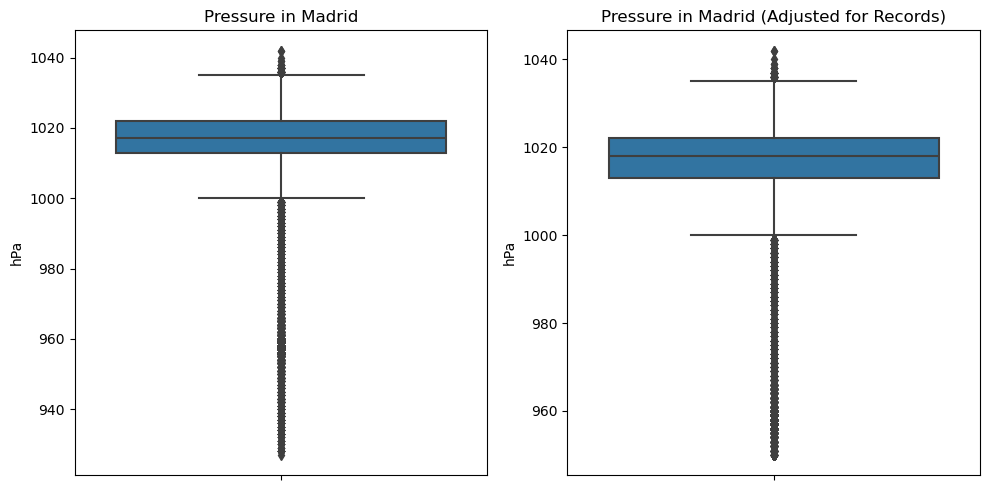

In [15]:
plot_city_boxplots([Madrid_df, Madrid_df[(Madrid_df["pressure"] >= 950)]],
                    "pressure",
                    ["Pressure in Madrid", "Pressure in Madrid (Adjusted for Records)"],
                    "hPa")

The extremely large outliers in pressure are not from Madrid. However, there are several low-pressure entries. We will remove values $\lt$ to 950 hPa and determine an appropriate imputation method for the remaining missing or erroneous data.

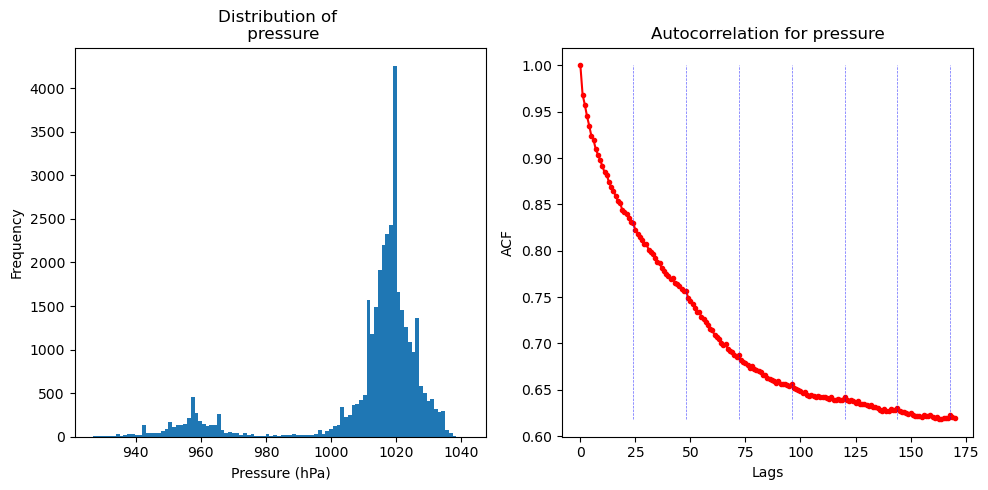

count      mean    std    min     25%     50%     75%     max
pressure  35064.0  1011.781  20.24  927.0  1013.0  1017.0  1022.0  1042.0

In [16]:
plot_find_city_trend(Madrid_df, "pressure", "Pressure (hPa)")
Madrid_df[["pressure"]].describe().round(3).T

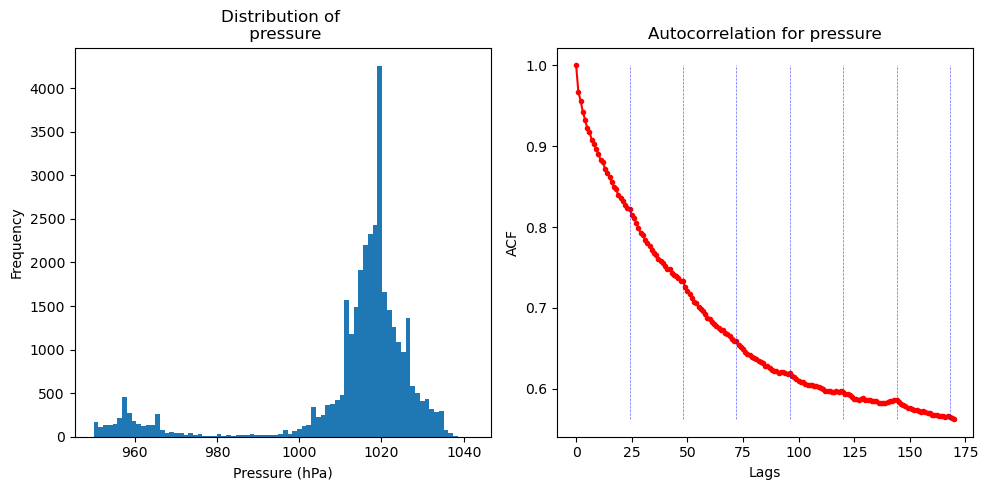

count      mean    std    min     25%     50%     75%     max
pressure  34405.0  1013.108  17.98  950.0  1013.0  1018.0  1022.0  1042.0

In [17]:
# Removing erroenous values
plot_find_city_trend(Madrid_df[Madrid_df["pressure"] >= 950], "pressure", "Pressure (hPa)", 80)
Madrid_df[Madrid_df["pressure"] >= 950][["pressure"]].describe().round(3).T

From the ACF plot above, we observe a smooth, gradual decline in autocorrelation values as the lag increases. This pattern indicates that the pressure data in Madrid exhibits strong autocorrelation at the shortest lags, meaning that recent observations are highly correlated with each other. There is no apparent seasonality in the data. As the lag increases, the autocorrelation decreases, suggesting that the relationship between observations weakens over time. However, even at higher lags (up to around 175), there remains a moderate level of autocorrelation.

This result suggests using a forward fill imputation method, where missing values are filled with data from the previous hour.

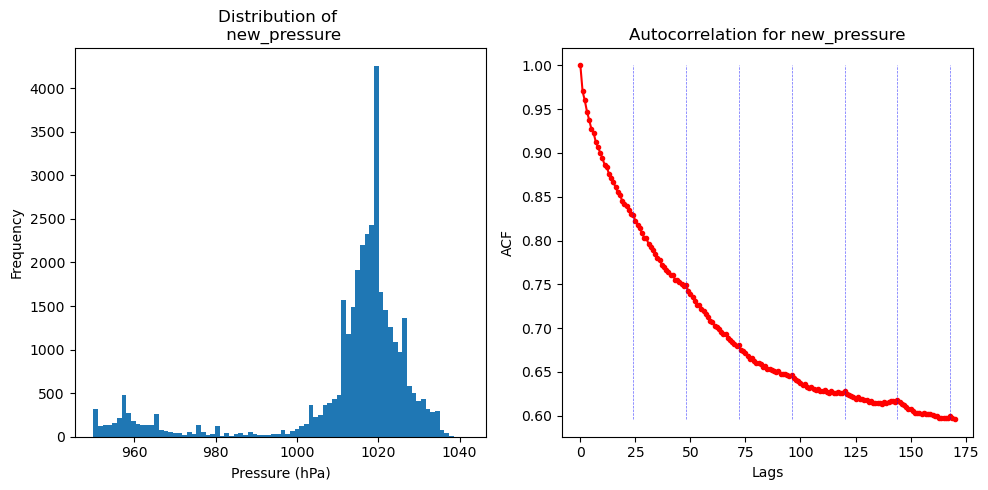

count      mean     std    min     25%     50%     75%     max
new_pressure  35064.0  1012.362  18.751  950.0  1013.0  1017.0  1022.0  1042.0

In [18]:
Madrid_df["new_pressure"] = Madrid_df["pressure"].copy()
Madrid_df["new_pressure"] = Madrid_df["pressure"].where((Madrid_df["pressure"] >= 950), np.nan)
Madrid_df["new_pressure"] = custom_ffill_n_hours(Madrid_df.copy()["new_pressure"], 1, True)

plot_find_city_trend(Madrid_df, "new_pressure", "Pressure (hPa)", 80)
Madrid_df[["new_pressure"]].describe().round(3).T

In [19]:
Madrid_df["pressure"] = Madrid_df["new_pressure"]
Madrid_df.drop(["new_pressure"], axis=1, inplace=True)

From the plots above, there are minimal differences between the original "pressure" and the imputed "new_pressure" data. Both histograms show similar distributions, with a prominent spike around 1020 hPa and a few small outliers at lower pressure values. The ACF plots also exhibit nearly identical decay patterns, indicating that the imputation has not significantly altered the temporal structure of the feature. Both features maintain strong temporal autocorrelation. Moving onto wind speed.

In [20]:
# Erroneous based on our research
print(Madrid_df[Madrid_df["wind_speed"] > 48].shape)

(0, 16)


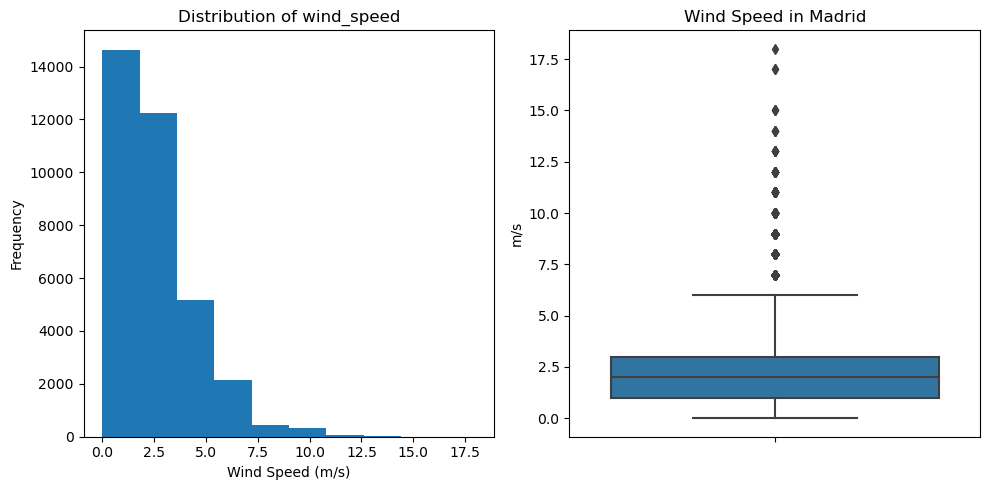

count   mean    std  min  25%  50%  75%   max
wind_speed  35064.0  2.434  1.973  0.0  1.0  2.0  3.0  18.0

In [21]:
plot_no_errors(Madrid_df, "wind_speed", ["Distribution of wind_speed", "Wind Speed in Madrid"],
               ["Wind Speed (m/s)", ""], ["", "m/s"], 10)
Madrid_df[["wind_speed"]].describe().round(3).T

The erroneous data we highlighted does not appear to be from Madrid, as there are no extreme wind speeds in Madrid. Therefore, we can leave the wind data as it is. 

Next, let’s take a look at the rain features.

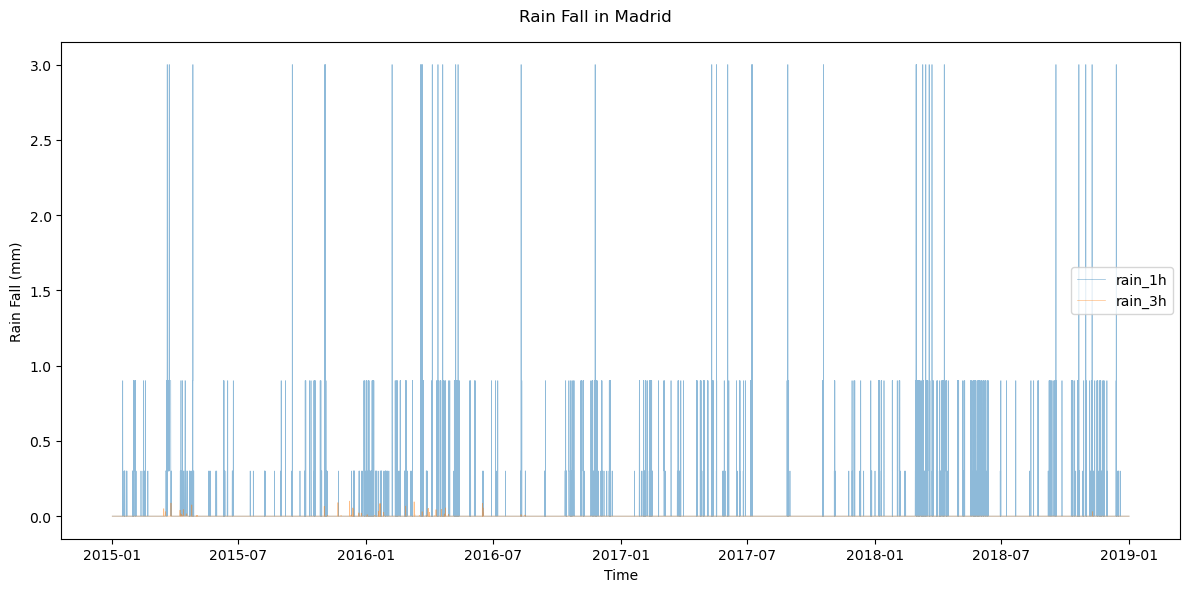

In [22]:
plot_linegraphs(Madrid_df, ["rain_1h", "rain_3h"], "Time", "Rain Fall (mm)", "Rain Fall in Madrid")

It seems that the error is evenly spread throughout the entire timeseries for Madrid. This contradicts our initial belief that large values in rain_1h were skewing the average. If this behavior is also observed in the other cities, we may need to consider dropping one or both features.

Moving forward, we will repeat the same analysis for the other four cities.

## 2.2 Bilbao

In [23]:
dates = check_duplicates_ts(Bilbao_df)
print(f"The number of dates that have unique feature data: {len(dates)}")

The number of dates that have unique feature data: 839


From the results above, we observe that there are 839 dates that are repeated but have unique row data.

In [24]:
Bilbao_df[Bilbao_df.index==dates[0]]

city_name    temp  temp_min  temp_max  pressure  \
time                                                                        
2015-07-02 22:00:00+02:00    Bilbao  291.58    291.15    292.15    1023.0   
2015-07-02 22:00:00+02:00    Bilbao  291.58    291.15    292.15    1023.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2015-07-02 22:00:00+02:00      93.0         1.0     310.0      0.0      0.0   
2015-07-02 22:00:00+02:00      93.0         1.0     310.0      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2015-07-02 22:00:00+02:00      0.0        90.0       300.0      drizzle   
2015-07-02 22:00:00+02:00      0.0        90.0       701.0         mist   

                               weather_description weather_icon  
time                                                             
2015-07-02 22:00:00+02:00  light intensity drizzle          09n  
2015-07-02 22:00:00+02:00                     mist          50n

Similar to Madrid, it may appear that the differences arises from the qualitative features.

Let's determine how many duplicates remain if we ignore these qualitative features.

In [25]:
cols_to_ignore = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']

dates2 = check_duplicates_ts(Bilbao_df.loc[:,~Bilbao_df.columns.isin(cols_to_ignore)])
print(f"The number of dates that have unique feature data: {len(dates2)} (Excluding Qualitative Features)")

The number of dates that have unique feature data: 0 (Excluding Qualitative Features)


Similar to Madrid, all duplicated rows for each hourly period are in the qualitative features. As before, we will retain only the first instance of each.

In [26]:
Bilbao_df.reset_index(inplace=True)
Bilbao_df.drop_duplicates(subset="time", keep="first", inplace=True)
Bilbao_df.set_index("time", inplace=True)
print(Bilbao_df.shape)
time_spacing(Bilbao_df)

(35064, 16)
This dataframe has 35064 rows.


time
0 days 01:00:00    35063
Name: count, dtype: int64

Now, the number of rows matches the energy dataset, and there are no missing hourly periods!

### 2.2.1 Outliers

In [27]:
# Erroneous based on our research
print(Bilbao_df[Bilbao_df["pressure"] > 1045].shape)
print(Bilbao_df[Bilbao_df["pressure"] < 950].shape)

(0, 16)
(0, 16)


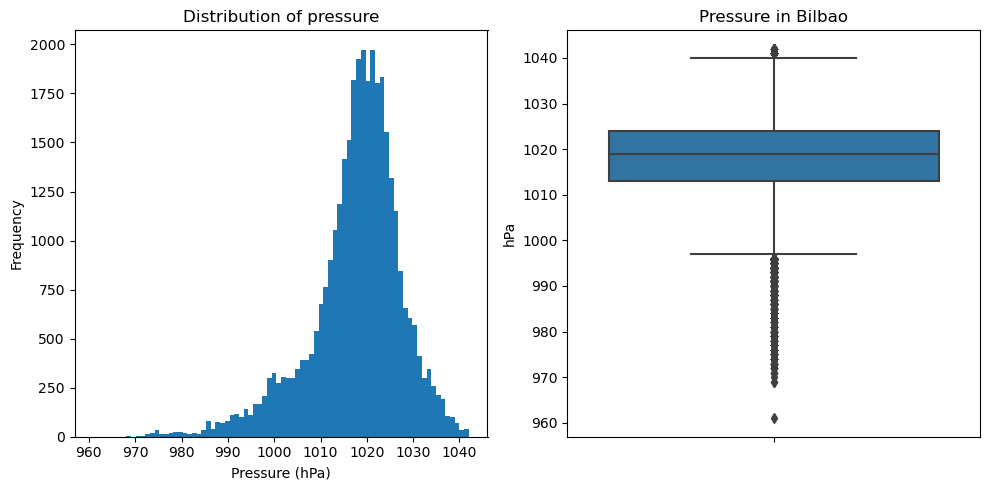

count      mean    std    min     25%     50%     75%     max
pressure  35064.0  1017.484  9.821  961.0  1013.0  1019.0  1024.0  1042.0

In [28]:
plot_no_errors(Bilbao_df, "pressure", ["Distribution of pressure", "Pressure in Bilbao"],
               ["Pressure (hPa)", ""], ["", "hPa"], 80)
Bilbao_df[["pressure"]].describe().round(3).T

There is no erroneous data in the pressure feature from Bilbao. Next, let’s examine the wind speeds.

In [29]:
# Erroneous based on our research
print(Bilbao_df[Bilbao_df["wind_speed"] > 48].shape)

(0, 16)


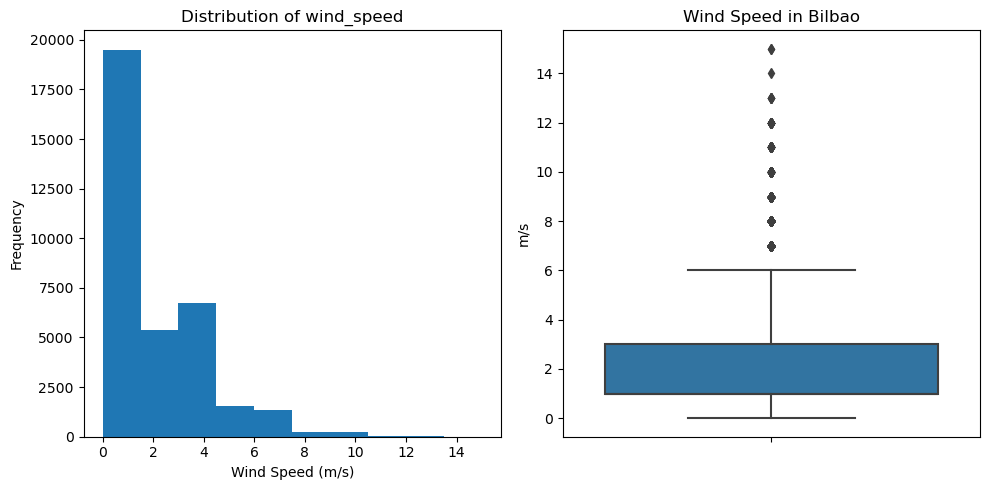

count   mean   std  min  25%  50%  75%   max
wind_speed  35064.0  1.958  1.87  0.0  1.0  1.0  3.0  15.0

In [30]:
plot_no_errors(Bilbao_df, "wind_speed", ["Distribution of wind_speed", "Wind Speed in Bilbao"],
               ["Wind Speed (m/s)", ""], ["", "m/s"], 10)
Bilbao_df[["wind_speed"]].describe().round(3).T

Similar to the pressure feature, there is no erroneous data in the wind speed feature from Bilbao. Next, let's take a look at the rain features.

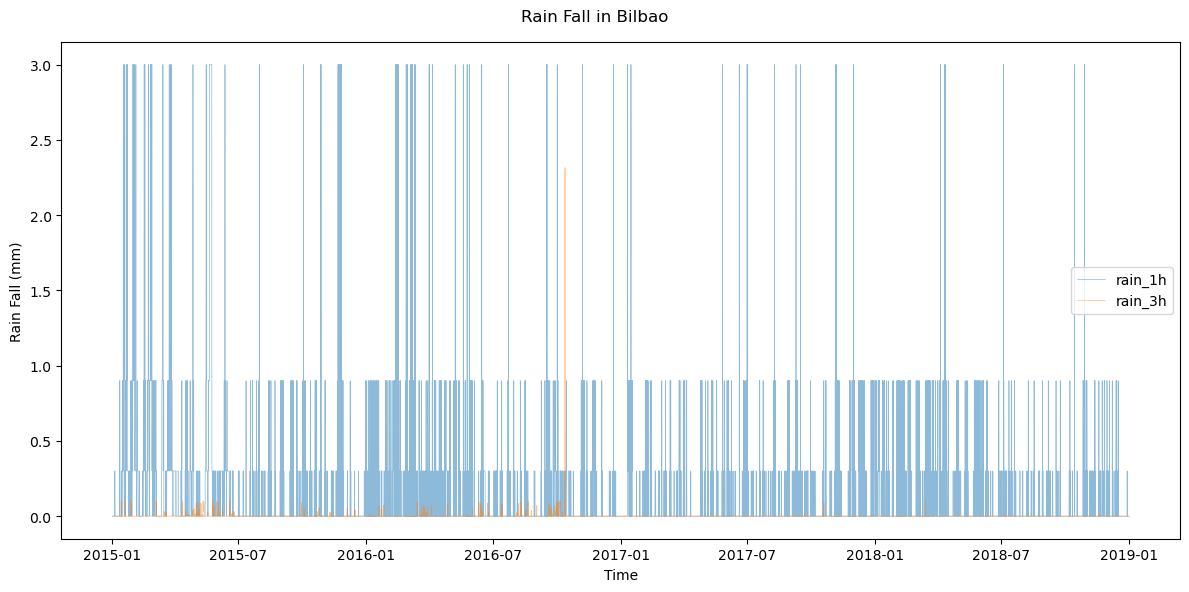

In [31]:
plot_linegraphs(Bilbao_df, ["rain_1h", "rain_3h"], "Time", "Rain Fall (mm)", "Rain Fall in Bilbao")

The error in the two rain features is also evenly spread throughout the entire timeseries for Bilbao.

## 2.3 Seville

In [32]:
dates = check_duplicates_ts(Seville_df)
print(f"The number of dates that have unique feature data: {len(dates)}")

The number of dates that have unique feature data: 466


From the results above, we observe that there are 466 dates that are repeated but have unique row data.

In [33]:
Seville_df[Seville_df.index==dates[0]]

city_name    temp  temp_min  temp_max  pressure  \
time                                                                        
2015-03-04 06:00:00+01:00   Seville  288.47    285.15    291.15    1026.0   
2015-03-04 06:00:00+01:00   Seville  288.47    285.15    291.15    1026.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2015-03-04 06:00:00+01:00     100.0         1.0      62.0      0.0      0.0   
2015-03-04 06:00:00+01:00     100.0         1.0      62.0      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2015-03-04 06:00:00+01:00      0.0        75.0       741.0          fog   
2015-03-04 06:00:00+01:00      0.0        75.0       701.0         mist   

                          weather_description weather_icon  
time                                                        
2015-03-04 06:00:00+01:00                 fog          50n  
2015-03-04 06:00:00+01:00                mist          50n

Let's determine how many duplicates remain if we ignore these qualitative features.

In [34]:
cols_to_ignore = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']

dates2 = check_duplicates_ts(Seville_df.loc[:,~Seville_df.columns.isin(cols_to_ignore)])
print(f"The number of dates that have unique feature data: {len(dates2)} (Excluding Qualitative Features)")

The number of dates that have unique feature data: 0 (Excluding Qualitative Features)


Once again, all differences in duplicated rows are due to variations in the qualitative features for the same hourly periods.

In [35]:
Seville_df.reset_index(inplace=True)
Seville_df.drop_duplicates(subset="time", keep="first", inplace=True)
Seville_df.set_index("time", inplace=True)
print(Seville_df.shape)
time_spacing(Seville_df)

(35064, 16)
This dataframe has 35064 rows.


time
0 days 01:00:00    35063
Name: count, dtype: int64

Now, the number of rows matches the energy dataset, and there are no missing hourly periods!

### 2.3.1 Outliers

In [36]:
# Erroneous based on our research
print(Seville_df[Seville_df["pressure"] > 1045].shape)
print(Seville_df[Seville_df["pressure"] < 950].shape)

(20, 16)
(0, 16)


There are definitely mis-entries (20 in total), as the highest recorded pressure in Spain is 1045 hPa.

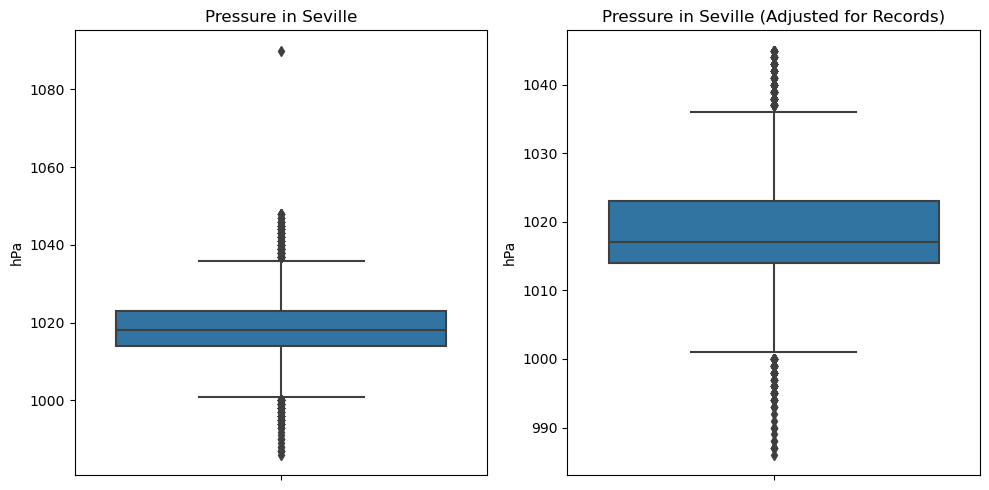

In [37]:
plot_city_boxplots([Seville_df, Seville_df[(Seville_df["pressure"] <= 1045)]],
                    "pressure",
                    ["Pressure in Seville", "Pressure in Seville (Adjusted for Records)"],
                    "hPa")

Now, let's remove pressure values $\gt$ 1045 hPa and determine the appropriate imputation method.

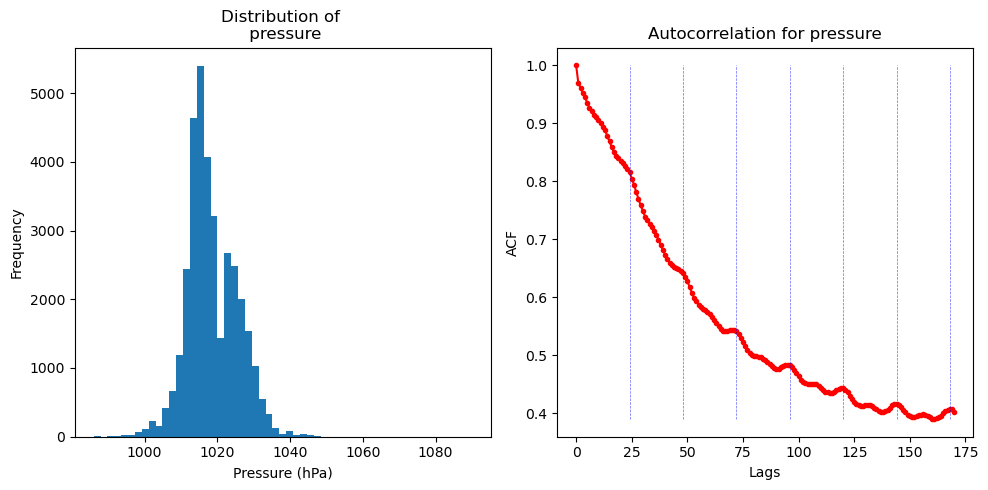

count      mean    std    min     25%     50%     75%     max
pressure  35064.0  1018.537  6.867  986.0  1014.0  1018.0  1023.0  1090.0

In [38]:
plot_find_city_trend(Seville_df, "pressure", "Pressure (hPa)", 55)
Seville_df[["pressure"]].describe().round(3).T

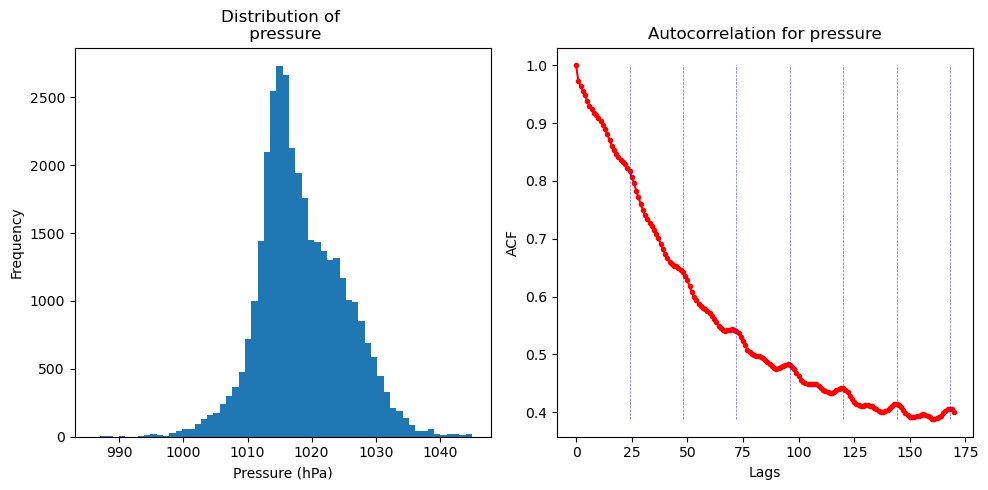

count     mean    std    min     25%     50%     75%     max
pressure  35044.0  1018.52  6.827  986.0  1014.0  1017.0  1023.0  1045.0

In [39]:
# Removing erroenous values
plot_find_city_trend(Seville_df[Seville_df["pressure"] <= 1045], "pressure", "Pressure (hPa)", 60)
Seville_df[Seville_df["pressure"] <= 1045][["pressure"]].describe().round(3).T

From the ACF plot above, we observe a gradual decline in autocorrelation values as the lag increases. This indicates that pressure in Seville is strongly correlated between consecutive hourly observations. There are no clear seasonal patterns, as evidenced by the smoothness of the plot at the vertical lines.

Similar to Madrid, we will use a forward fill imputation method, using data from the previous hour.

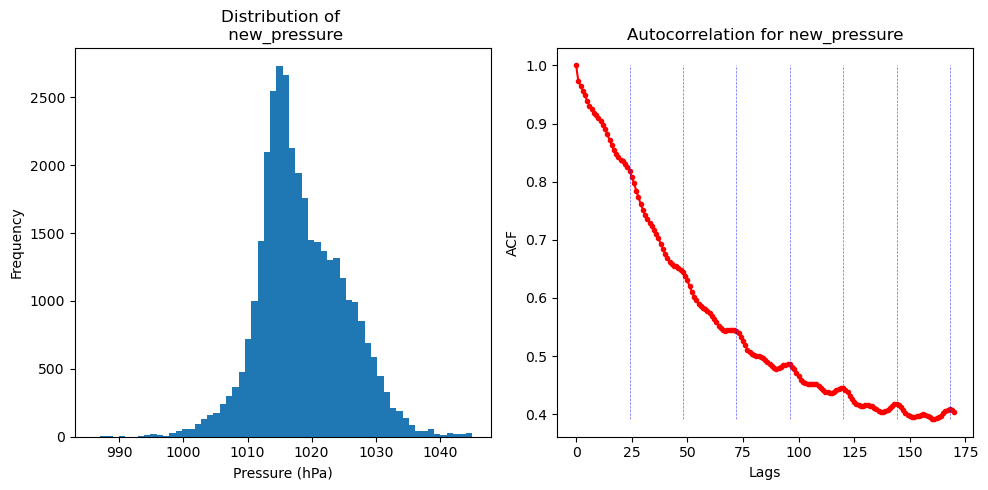

count      mean   std    min     25%     50%     75%     max
new_pressure  35064.0  1018.533  6.85  986.0  1014.0  1018.0  1023.0  1045.0

In [40]:
Seville_df["new_pressure"] = Seville_df["pressure"].copy()
Seville_df["new_pressure"] = Seville_df["pressure"].where((Seville_df["pressure"] <= 1045), np.nan)
Seville_df["new_pressure"] = custom_ffill_n_hours(Seville_df.copy()["new_pressure"], 1, True)

plot_find_city_trend(Seville_df, "new_pressure", "Pressure (hPa)", 60)
Seville_df[["new_pressure"]].describe().round(3).T

In [41]:
Seville_df["pressure"] = Seville_df["new_pressure"]
Seville_df.drop(["new_pressure"], axis=1, inplace=True)

The distribution of the 'new_pressure' data shows slightly more variation, with a broader spread and lower peak compared to the original 'pressure' data. This change is mainly due to the imputation of values greater than 1045 hPa. Small spikes are more pronounced in the higher pressure range in the new data. In terms of autocorrelation, both datasets exhibit a similar decay pattern. Overall, the differences are minor, and the imputation has successfully preserved the temporal structure and general characteristics of the data. Moving onto wind speed.

In [42]:
# Erroneous based on our research
print(Seville_df[Seville_df["wind_speed"] > 48].shape)

(0, 16)


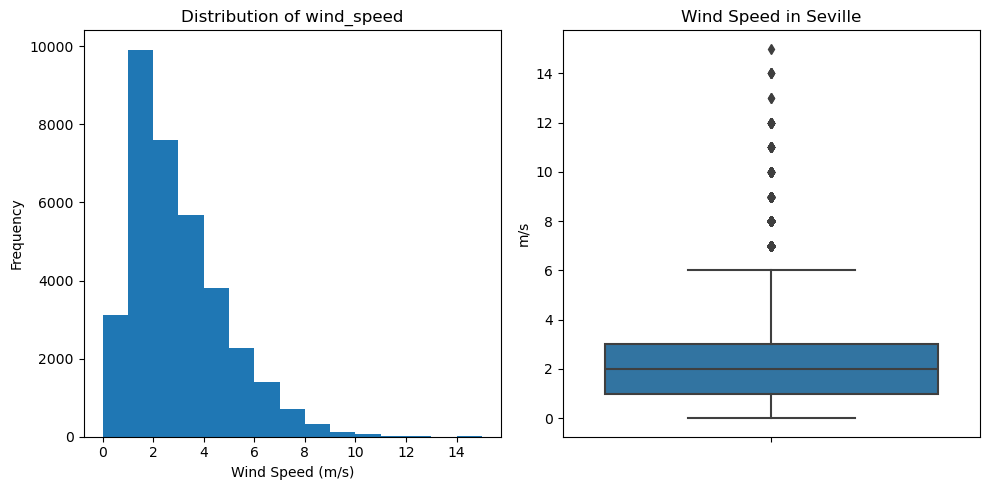

count   mean    std  min  25%  50%  75%   max
wind_speed  35064.0  2.483  1.869  0.0  1.0  2.0  3.0  15.0

In [43]:
plot_no_errors(Seville_df, "wind_speed", ["Distribution of wind_speed", "Wind Speed in Seville"],
               ["Wind Speed (m/s)", ""], ["", "m/s"], 15)
Seville_df[["wind_speed"]].describe().round(3).T

The erroneous data we highlighted does not appear to be from Seville either, as there are no extreme wind speeds recorded. Therefore, we can leave the wind data as it is.

Next, let’s examine the rain features.

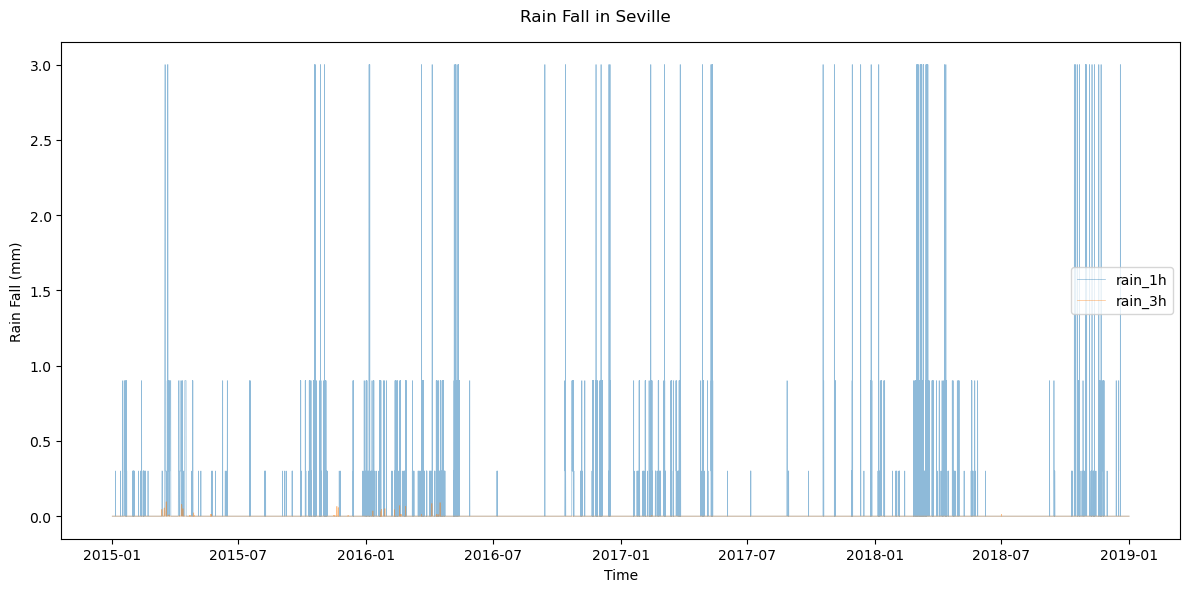

In [44]:
plot_linegraphs(Seville_df, ["rain_1h", "rain_3h"], "Time", "Rain Fall (mm)", "Rain Fall in Seville")

The error in the two rain features is also spread throughout the entire timeseries for Seville.

## 2.4 Barcelona

In [45]:
dates = check_duplicates_ts(Barcelona_df)
print(f"The number of dates that have unique feature data: {len(dates)}")

The number of dates that have unique feature data: 389


From the results above, we observe that there are 389 dates that are repeated but have unique row data.

In [46]:
Barcelona_df[Barcelona_df.index==dates[0]]

city_name    temp  temp_min  temp_max  pressure  \
time                                                                         
2015-03-20 21:00:00+01:00  Barcelona  286.81    282.59    291.48    1013.0   
2015-03-20 21:00:00+01:00  Barcelona  286.81    282.59    291.48    1013.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2015-03-20 21:00:00+01:00      76.0        12.0      50.0      0.3      0.0   
2015-03-20 21:00:00+01:00      76.0        12.0      50.0      0.3      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2015-03-20 21:00:00+01:00      0.0        40.0       500.0         rain   
2015-03-20 21:00:00+01:00      0.0        40.0       301.0      drizzle   

                          weather_description weather_icon  
time                                                        
2015-03-20 21:00:00+01:00          light rain          10n  
2015-03-20 21:00:00+01:00             drizzle          09n

Let's determine how many duplicates remain if we ignore these qualitative features.

In [47]:
cols_to_ignore = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']

dates2 = check_duplicates_ts(Barcelona_df.loc[:,~Barcelona_df.columns.isin(cols_to_ignore)])
print(f"The number of dates that have unique feature data: {len(dates2)} (Excluding Qualitative Features)")

The number of dates that have unique feature data: 0 (Excluding Qualitative Features)


Once again, all differences in duplicated rows are due to variations in the qualitative features for the same hourly periods.

In [48]:
Barcelona_df.reset_index(inplace=True)
Barcelona_df.drop_duplicates(subset="time", keep="first", inplace=True)
Barcelona_df.set_index("time", inplace=True)
print(Barcelona_df.shape)
time_spacing(Barcelona_df)

(35064, 16)
This dataframe has 35064 rows.


time
0 days 01:00:00    35063
Name: count, dtype: int64

Now, the number of rows matches the energy dataset, and there are no missing hourly periods!

### 2.4.1 Outliers

In [49]:
# Erroneous based on our research
print(Barcelona_df[Barcelona_df["pressure"] > 1045].shape)
print(Barcelona_df[Barcelona_df["pressure"] < 950].shape)

(45, 16)
(16, 16)


In the Barcelona dataset, there are mis-entries in the pressure feature that violate both the upper and lower bounds of recorded pressures in Spain.

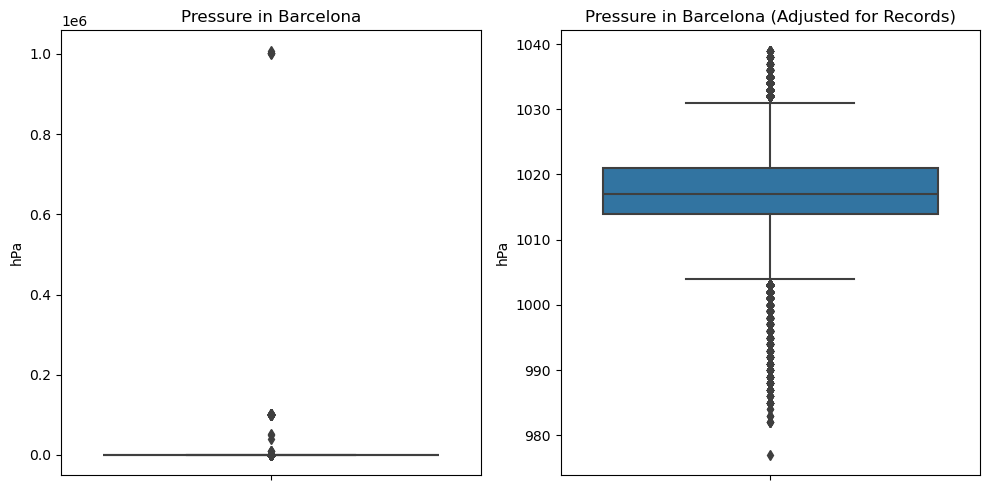

In [50]:
plot_city_boxplots([Barcelona_df, Barcelona_df[(Barcelona_df["pressure"] >= 950) & (Barcelona_df["pressure"] <= 1045)]],
                    "pressure",
                    ["Pressure in Barcelona", "Pressure in Barcelona (Adjusted for Records)"],
                    "hPa")

Now, let's remove pressure values $\lt$ 950 hPa and $\gt$ 1045 hPa and determine the appropriate imputation method.

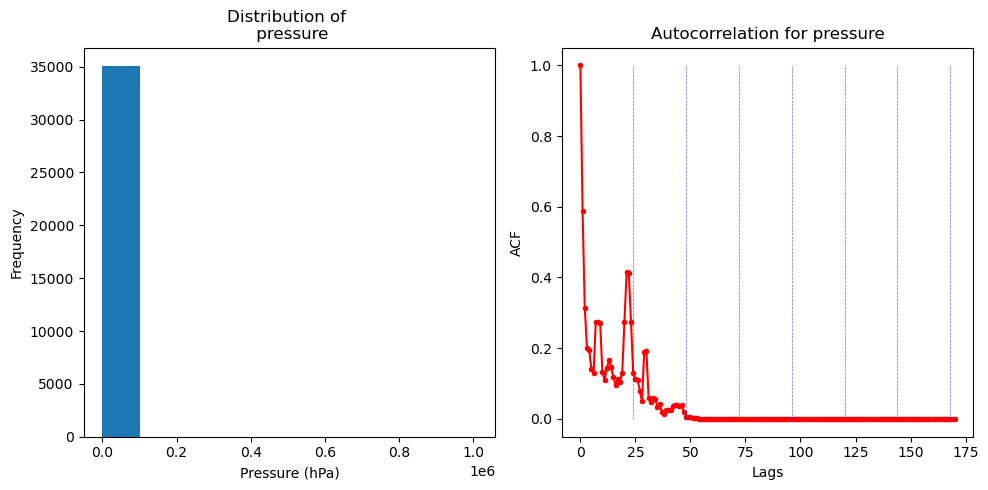

count      mean        std  min     25%     50%     75%        max
pressure  35064.0  1287.211  13463.025  0.0  1014.0  1017.0  1021.0  1008371.0

In [51]:
plot_find_city_trend(Barcelona_df, "pressure", "Pressure (hPa)", 10)
Barcelona_df[["pressure"]].describe().round(3).T

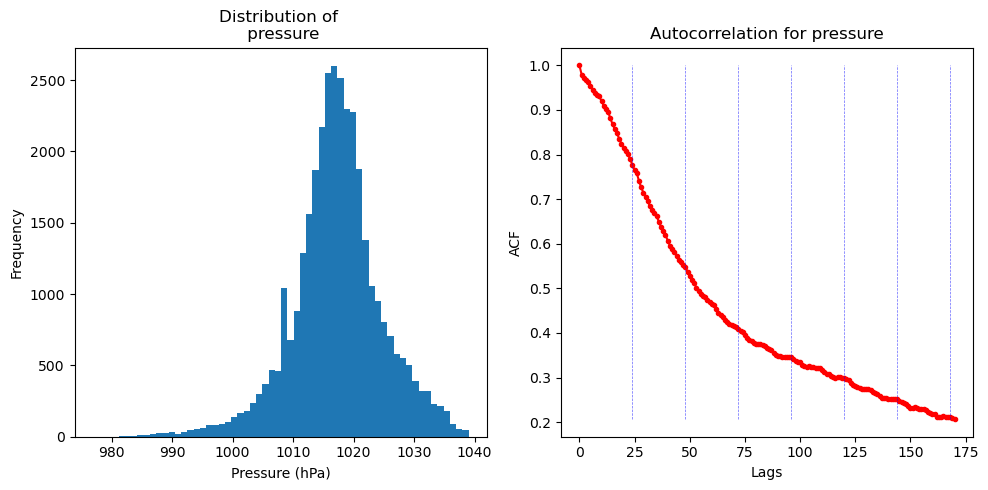

count      mean    std    min     25%     50%     75%     max
pressure  35003.0  1017.331  7.395  977.0  1014.0  1017.0  1021.0  1039.0

In [52]:
# Removing erroenous values
plot_find_city_trend(Barcelona_df[(Barcelona_df["pressure"] >= 950) & (Barcelona_df["pressure"] <= 1045)], "pressure", "Pressure (hPa)", 60)
Barcelona_df[(Barcelona_df["pressure"] >= 950) & (Barcelona_df["pressure"] <= 1045)][["pressure"]].describe().round(3).T

From the ACF plot above, similar to the other cities, it shows a smooth, gradual decline in autocorrelation values as the lag increases. Compared to Madrid and Bilbao, the autocorrelation values in Barcelona drop more rapidly.

This suggests that a forward fill imputation using data from the previous hour would be appropriate.

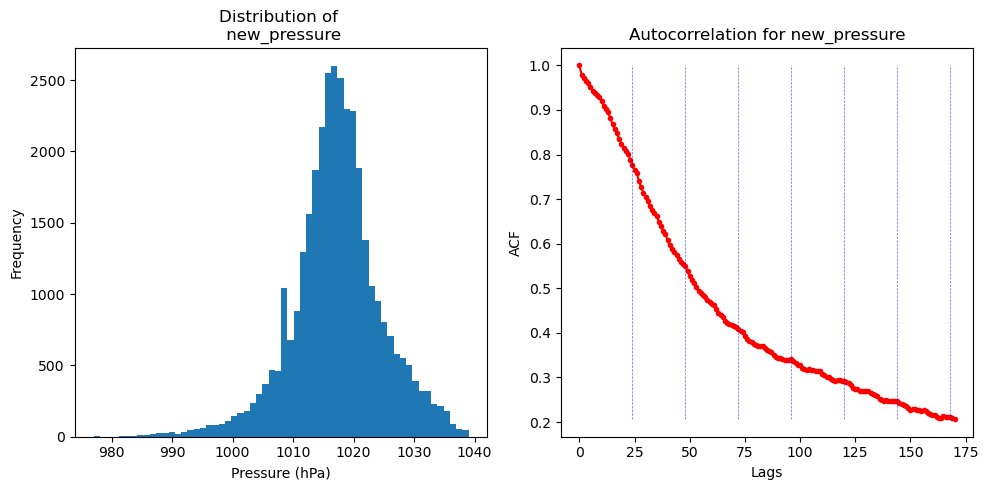

count     mean    std    min     25%     50%     75%     max
new_pressure  35064.0  1017.32  7.405  977.0  1014.0  1017.0  1021.0  1039.0

In [53]:
Barcelona_df["new_pressure"] = Barcelona_df["pressure"].copy()
Barcelona_df["new_pressure"] = Barcelona_df["pressure"].where((Barcelona_df["pressure"] >= 950) & (Barcelona_df["pressure"] <= 1045), np.nan)
Barcelona_df["new_pressure"] = custom_ffill_n_hours(Barcelona_df.copy()["new_pressure"], 1, True)

plot_find_city_trend(Barcelona_df, "new_pressure", "Pressure (hPa)", 60)
Barcelona_df[["new_pressure"]].describe().round(3).T

In [54]:
Barcelona_df["pressure"] = Barcelona_df["new_pressure"]
Barcelona_df.drop(["new_pressure"], axis=1, inplace=True)

The pressure data in Barcelona looks good! Let’s move on to the wind speed data.

In [55]:
# Erroneous based on our research
print(Barcelona_df[Barcelona_df["wind_speed"] > 48].shape)

(0, 16)


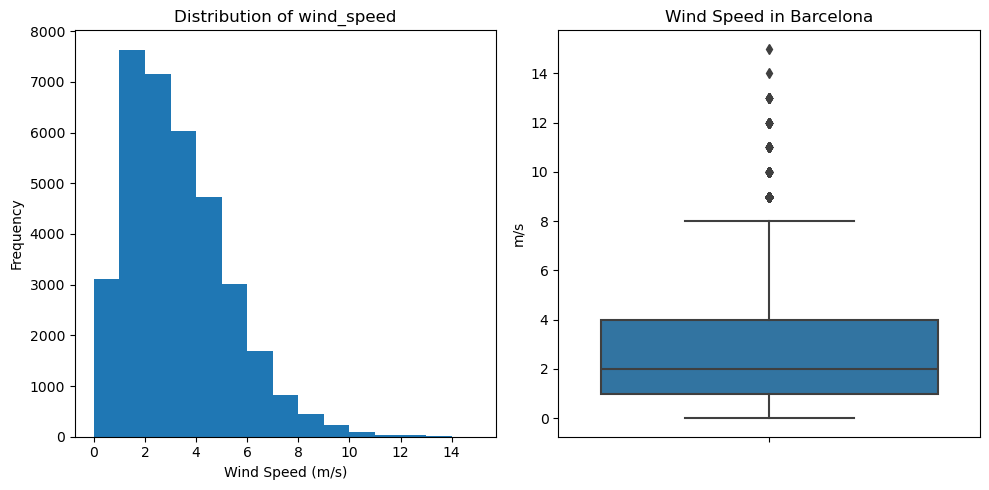

count   mean    std  min  25%  50%  75%   max
wind_speed  35064.0  2.783  1.996  0.0  1.0  2.0  4.0  15.0

In [56]:
plot_no_errors(Barcelona_df, "wind_speed", ["Distribution of wind_speed", "Wind Speed in Barcelona"],
               ["Wind Speed (m/s)", ""], ["", "m/s"], 15)
Barcelona_df[["wind_speed"]].describe().round(3).T

The erroneous data we highlighted does not appear to be from Barcelona either, as no extreme wind speeds are recorded. Therefore, we can leave the wind data as it is.

Next, let’s examine the rain features.

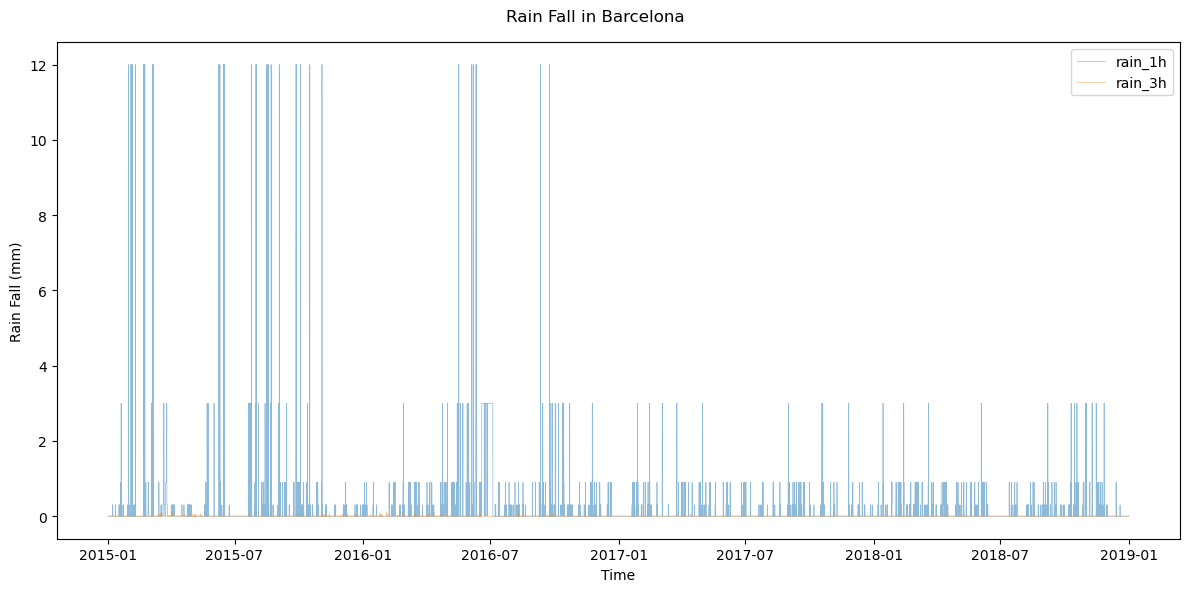

In [57]:
plot_linegraphs(Barcelona_df, ["rain_1h", "rain_3h"], "Time", "Rain Fall (mm)", "Rain Fall in Barcelona")

The error in the two rain features is also spread throughout the entire timeseries for Barcelona.

## 2.5 Valencia

In [58]:
dates = check_duplicates_ts(Valencia_df)
print(f"The number of dates that have unique feature data: {len(dates)}")

The number of dates that have unique feature data: 76


From the results above, we observe that there are 76 dates that are repeated but have unique row data.

In [59]:
Valencia_df[Valencia_df.index==dates[0]]

city_name    temp  temp_min  temp_max  pressure  \
time                                                                        
2015-06-15 21:00:00+02:00  Valencia  289.61    288.65    290.93    1018.0   
2015-06-15 21:00:00+02:00  Valencia  289.61    288.65    290.93    1018.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2015-06-15 21:00:00+02:00     100.0         3.0     330.0      0.9      0.0   
2015-06-15 21:00:00+02:00     100.0         3.0     330.0      0.9      0.0   

                           snow_3h  clouds_all  weather_id  weather_main  \
time                                                                       
2015-06-15 21:00:00+02:00      0.0        75.0       501.0          rain   
2015-06-15 21:00:00+02:00      0.0        75.0       200.0  thunderstorm   

                                    weather_description weather_icon  
time                                                                  
2015-06-15 21:00:00+02:00                 moderate rain          10d  
2015-06-15 21:00:00+02:00  thunderstorm with light rain          11d

Let's determine how many duplicates remain if we ignore these qualitative features.

In [60]:
cols_to_ignore = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']

dates2 = check_duplicates_ts(Valencia_df.loc[:,~Valencia_df.columns.isin(cols_to_ignore)])
print(f"The number of dates that have unique feature data: {len(dates2)} (Excluding Qualitative Features)")

The number of dates that have unique feature data: 0 (Excluding Qualitative Features)


Once again, all differences in duplicated rows are due to variations in the qualitative features for the same hourly periods.

In [61]:
Valencia_df.reset_index(inplace=True)
Valencia_df.drop_duplicates(subset="time", keep="first", inplace=True)
Valencia_df.set_index("time", inplace=True)
print(Valencia_df.shape)
time_spacing(Valencia_df)

(35064, 16)
This dataframe has 35064 rows.


time
0 days 01:00:00    35063
Name: count, dtype: int64

Now, the number of rows matches the energy dataset, and there are no missing hourly periods!

### 2.5.1 Outliers

In [62]:
# Erroneous based on our research
print(Valencia_df[Valencia_df["pressure"] > 1045].shape)
print(Valencia_df[Valencia_df["pressure"] < 950].shape)

(366, 16)
(0, 16)


There are definitely mis-entries (366 in total), as the highest recorded pressure in Spain is 1045 hPa.

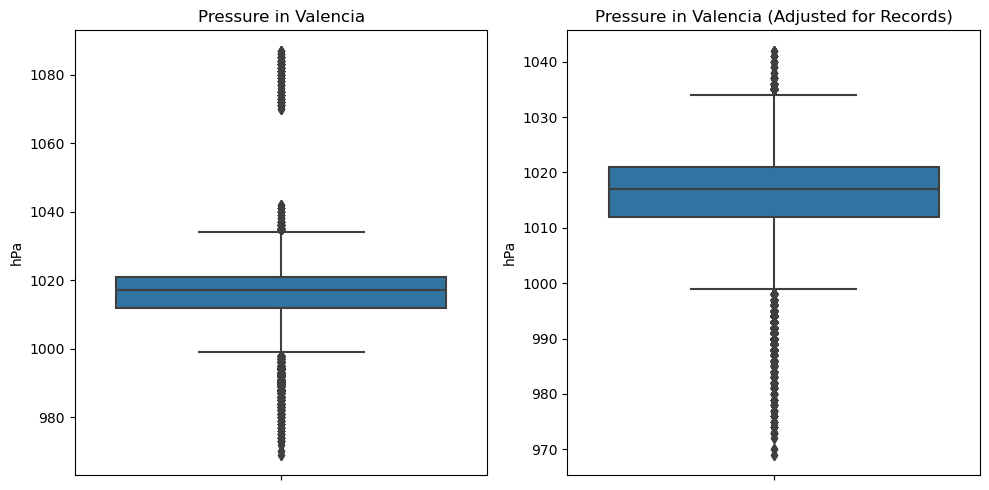

In [63]:
plot_city_boxplots([Valencia_df, Valencia_df[(Valencia_df["pressure"] <= 1045)]],
                    "pressure",
                    ["Pressure in Valencia", "Pressure in Valencia (Adjusted for Records)"],
                    "hPa")

Now, let's remove pressure values $\gt$ 1045 hPa and determine the appropriate imputation method.

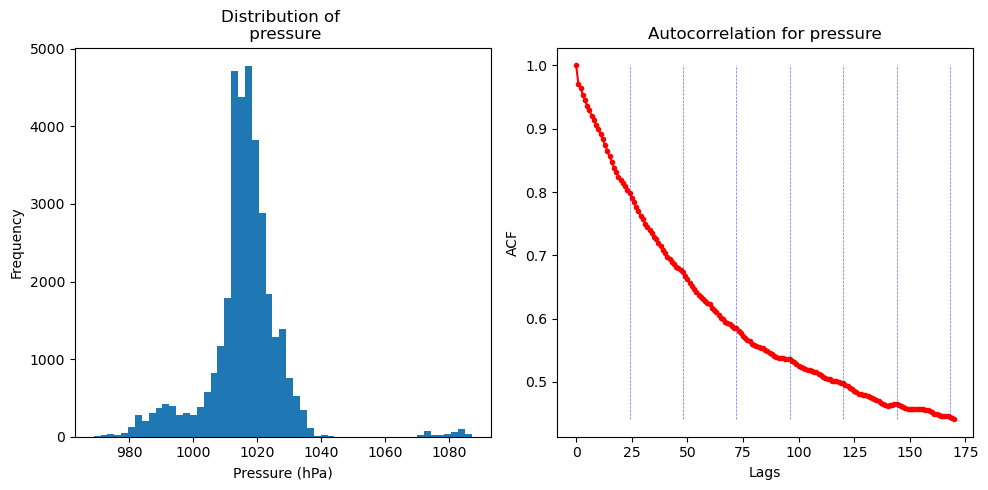

count      mean     std    min     25%     50%     75%     max
pressure  35064.0  1015.979  11.938  969.0  1012.0  1017.0  1021.0  1087.0

In [64]:
plot_find_city_trend(Valencia_df, "pressure", "Pressure (hPa)", 55)
Valencia_df[["pressure"]].describe().round(3).T

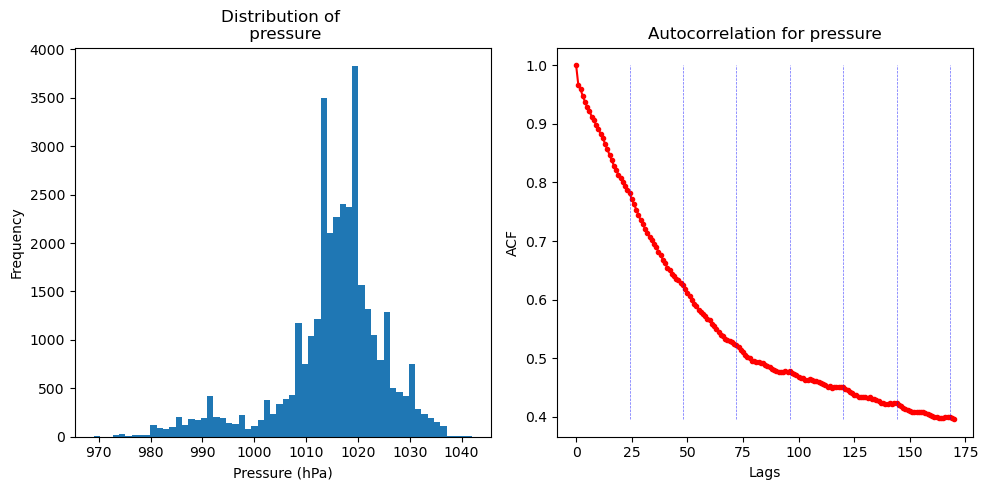

count      mean     std    min     25%     50%     75%     max
pressure  34698.0  1015.311  10.048  969.0  1012.0  1017.0  1021.0  1042.0

In [65]:
# Removing erroenous values
plot_find_city_trend(Valencia_df[Valencia_df["pressure"] <= 1045], "pressure", "Pressure (hPa)", 60)
Valencia_df[Valencia_df["pressure"] <= 1045][["pressure"]].describe().round(3).T

From the ACF plot above, there is a clear seasonal trend in wind speed in Seville.

This suggests that we should impute missing values using data from the previous day.

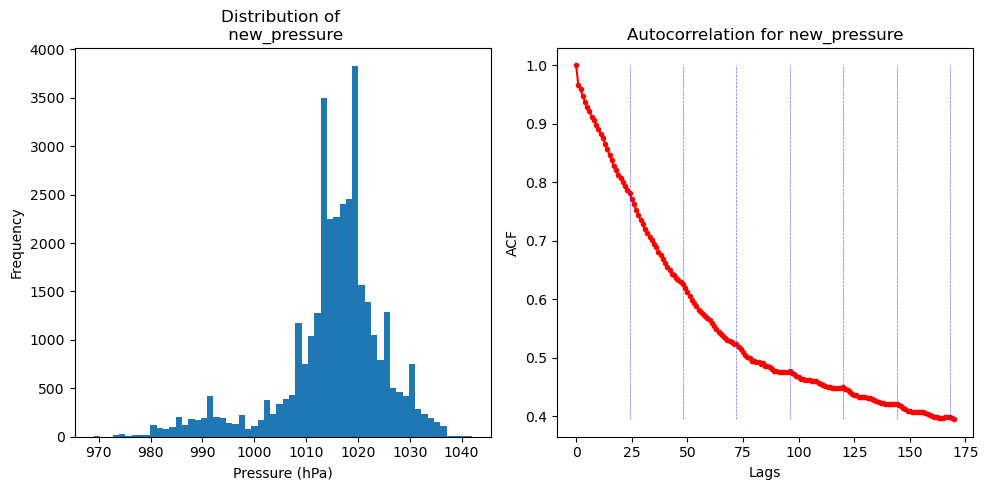

count      mean     std    min     25%     50%     75%     max
new_pressure  35064.0  1015.326  10.002  969.0  1012.0  1017.0  1021.0  1042.0

In [66]:
Valencia_df["new_pressure"] = Valencia_df["pressure"].copy()
Valencia_df["new_pressure"] = Valencia_df["pressure"].where((Valencia_df["pressure"] <= 1045), np.nan)
Valencia_df["new_pressure"] = custom_ffill_n_hours(Valencia_df.copy()["new_pressure"], 1, True)

plot_find_city_trend(Valencia_df, "new_pressure", "Pressure (hPa)", 60)
Valencia_df[["new_pressure"]].describe().round(3).T

In [67]:
Valencia_df["pressure"] = Valencia_df["new_pressure"]
Valencia_df.drop(["new_pressure"], axis=1, inplace=True)

The pressure data in Valencia looks good! Let’s move on to the wind speed data.

In [68]:
# Erroneous based on our research
print(Valencia_df[Valencia_df["wind_speed"] > 48].shape)

(3, 16)


It appears that Valencia is the city where the pressure data has exceeded the ceiling wind speed of 48 m/s.

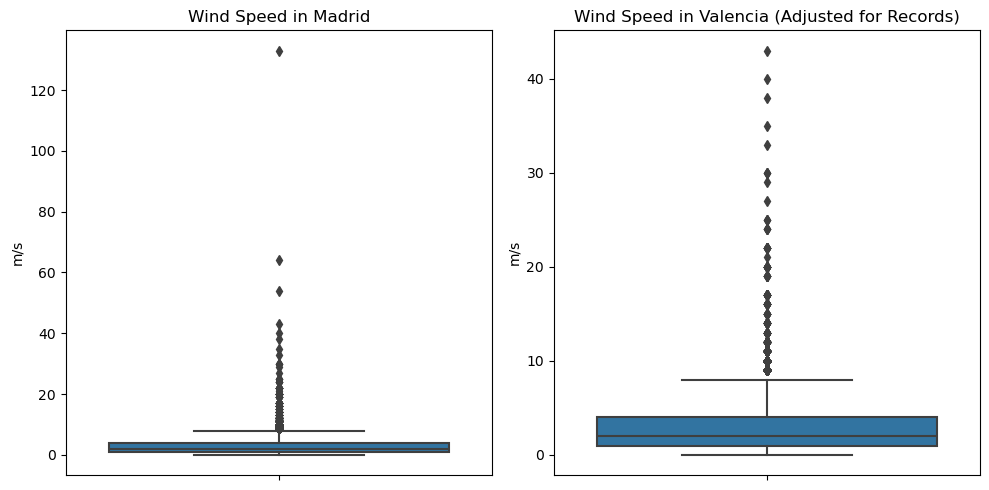

In [69]:
plot_city_boxplots([Valencia_df, Valencia_df[(Valencia_df["wind_speed"] <= 48)]],
                    "wind_speed",
                    ["Wind Speed in Madrid", "Wind Speed in Valencia (Adjusted for Records)"],
                    "m/s")

Now, let's remove wind speed values $\gt$ 48 m/s and determine the appropriate imputation method

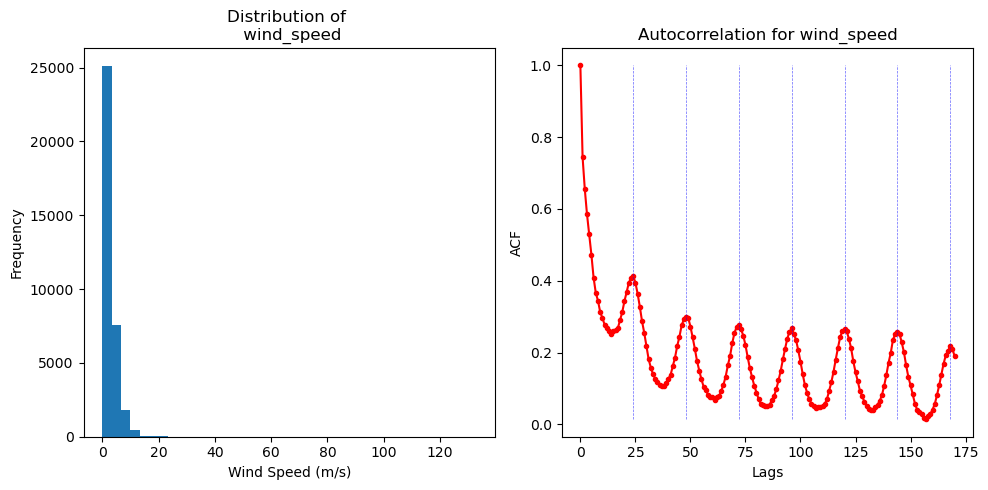

count   mean    std  min  25%  50%  75%    max
wind_speed  35064.0  2.692  2.583  0.0  1.0  2.0  4.0  133.0

In [70]:
plot_find_city_trend(Valencia_df, "wind_speed", "Wind Speed (m/s)", 40)
Valencia_df[["wind_speed"]].describe().round(3).T

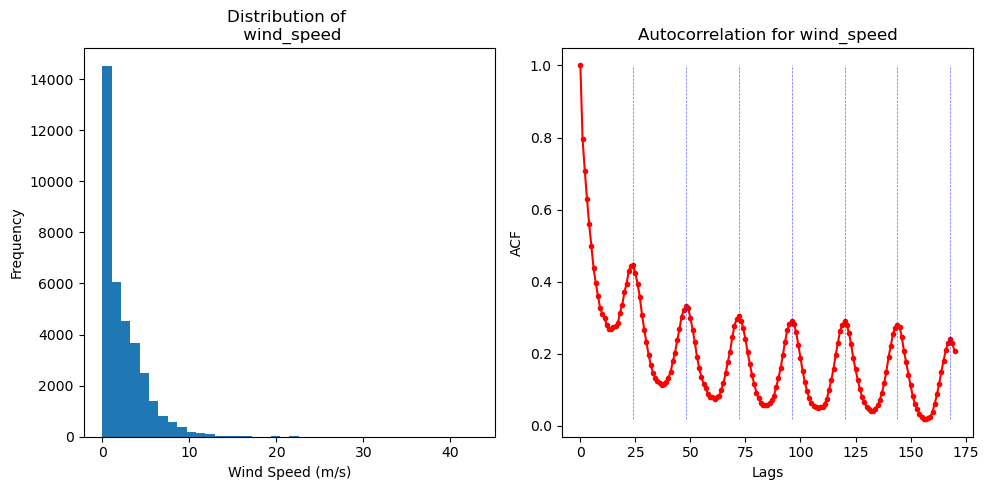

count   mean    std  min  25%  50%  75%   max
wind_speed  35061.0  2.686  2.451  0.0  1.0  2.0  4.0  43.0

In [71]:
# Removing erroenous values
plot_find_city_trend(Valencia_df[Valencia_df["wind_speed"] <= 48], "wind_speed", "Wind Speed (m/s)", 40)
Valencia_df[Valencia_df["wind_speed"] <= 48][["wind_speed"]].describe().round(3).T

From the plots above, we observe that the wind speed data is highly skewed towards lower values, with very few high wind speed observations. The autocorrelation reveals a strong periodic component, indicating regular fluctuations in wind speed over time.

We will impute missing values using the wind speed from the previous day.

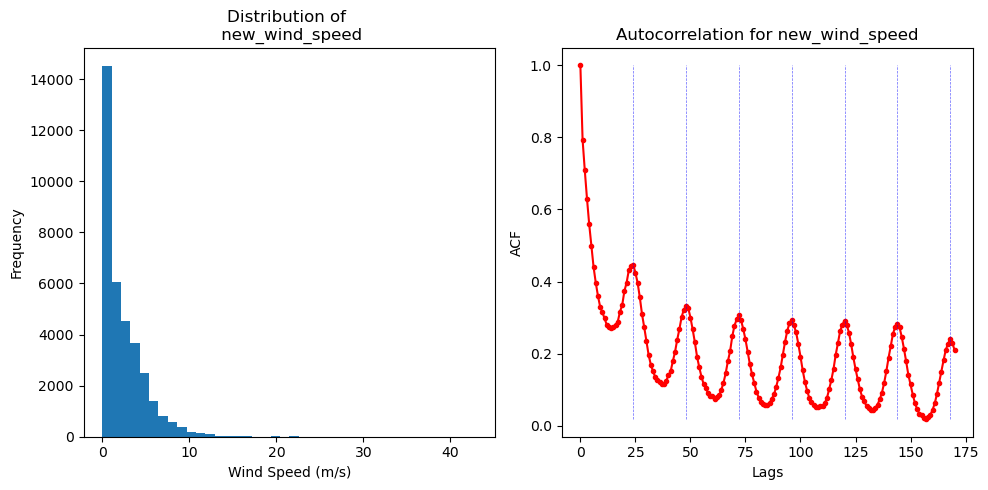

count   mean    std  min  25%  50%  75%   max
new_wind_speed  35064.0  2.686  2.453  0.0  1.0  2.0  4.0  43.0

In [72]:
Valencia_df["new_wind_speed"] = Valencia_df["wind_speed"].copy()
Valencia_df["new_wind_speed"] = Valencia_df["wind_speed"].where((Valencia_df["wind_speed"] <= 48), np.nan)
Valencia_df["new_wind_speed"] = impute_previous_n_days(Valencia_df.copy()["new_wind_speed"], 1, True)

plot_find_city_trend(Valencia_df, "new_wind_speed", "Wind Speed (m/s)", 40)
Valencia_df[["new_wind_speed"]].describe().round(3).T

In [73]:
Valencia_df["wind_speed"] = Valencia_df["new_wind_speed"]
Valencia_df.drop(["new_wind_speed"], axis=1, inplace=True)

The wind_speed data in Valencia looks good!

Next, let's examine the rain features.

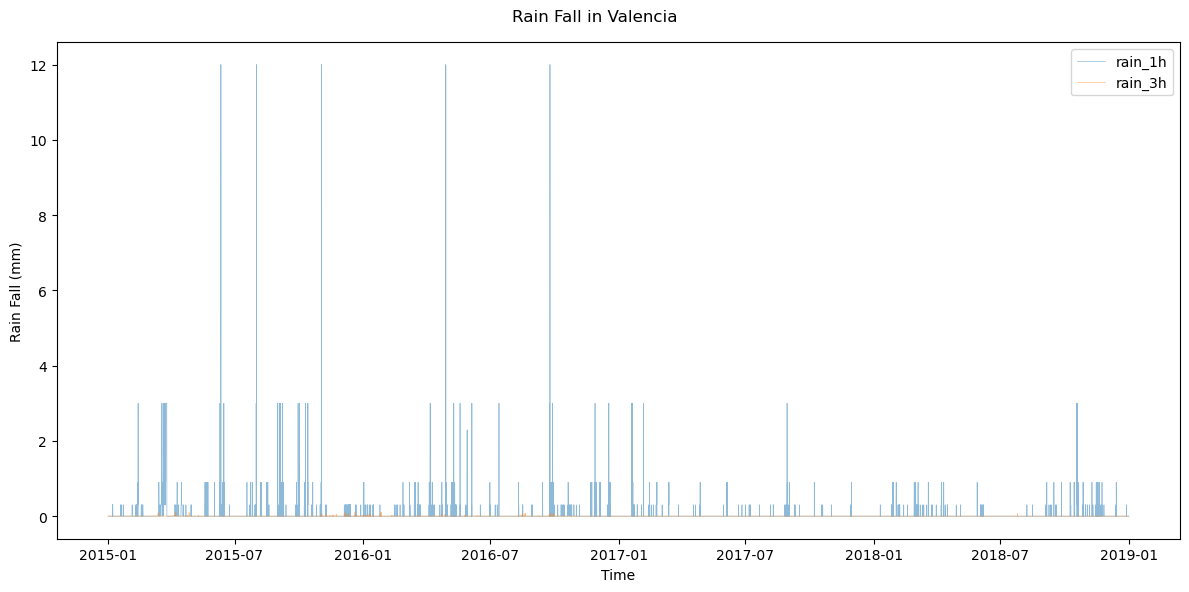

In [74]:
plot_linegraphs(Valencia_df, ["rain_1h", "rain_3h"], "Time", "Rain Fall (mm)", "Rain Fall in Valencia")

The error in the two rain features is also spread throughout the entire timeseries for Seville.

## 2.6 Summary of Analysis By Cities

In [75]:
df = pd.concat([Barcelona_df, Valencia_df, Seville_df, Madrid_df, Bilbao_df])
df.describe().round(3)

temp    temp_min    temp_max    pressure    humidity  wind_speed  \
count  175320.000  175320.000  175320.000  175320.000  175320.000  175320.000   
mean      289.708     288.428     291.172    1016.205      68.032       2.469   
std         8.025       7.948       8.614      11.607      21.838       2.063   
min       262.240     262.240     262.240     950.000       0.000       0.000   
25%       283.830     282.785     284.909    1013.000      53.000       1.000   
50%       289.150     288.150     290.150    1018.000      72.000       2.000   
75%       295.240     294.150     297.150    1022.000      87.000       4.000   
max       315.600     315.150     321.150    1045.000     100.000      43.000   

         wind_deg     rain_1h     rain_3h     snow_3h  clouds_all  weather_id  
count  175320.000  175320.000  175320.000  175320.000  175320.000  175320.000  
mean      166.725       0.069       0.000       0.005      24.344     763.621  
std       116.549       0.386       0.007       0.225      30.340     103.113  
min         0.000       0.000       0.000       0.000       0.000     200.000  
25%        56.000       0.000       0.000       0.000       0.000     800.000  
50%       178.000       0.000       0.000       0.000      16.000     800.000  
75%       270.000       0.000       0.000       0.000      40.000     801.000  
max       360.000      12.000       2.315      21.500     100.000     804.000

From the summary above, the features 'pressure' and 'wind_speed' have been corrected. Based on our analysis of the energy dataset, including a rain feature would be valuable. However, we observed that the recorded rainfall from the past 3 hours was consistently much less than that from the past hour. Therefore, we will drop the 'rain_3h' feature. 

*Aside:* Since the temperature features are recorded in Kelvin, we will convert them to degrees Celsius before analyzing.

In [76]:
df.drop(['rain_3h'], axis=1, inplace=True)
temp_cols = ["temp", "temp_min", "temp_max"]
for temp_col in temp_cols:
    df[temp_col] = df[temp_col].apply(lambda x: x - 273.15)
df[temp_cols].describe().round(3)

temp    temp_min    temp_max
count  175320.000  175320.000  175320.000
mean       16.558      15.278      18.022
std         8.025       7.948       8.614
min       -10.910     -10.910     -10.910
25%        10.680       9.635      11.759
50%        16.000      15.000      17.000
75%        22.090      21.000      24.000
max        42.450      42.000      48.000

# 3.0 Weather Features Exploration

In the work outlined above, we have addressed the erroneous values identified through our research. Next, we will analyze in detail the features that, based on our knowledge, are likely to have a direct impact on the target variable.

We will now reintroduce the target variable, "total load actual," back into the dataset.

In [77]:
TARGET = "total load actual"
df2 = pd.read_csv("energy_dataset_clean.csv")[["time", TARGET]]
df3 = merge_energy_weather(df2, df[["city_name", "pressure", "wind_speed", "rain_1h", "humidity", "snow_3h", "clouds_all"] + temp_cols])

## 3.1 Temperature Features



Temperature significantly influences electricity demand due to its impact on heating and cooling needs. In colder weather, such as during winter, the demand for heating increases, potentially leading to higher electricity usage for people that rely on electric heaters. Conversely, in hotter weather, especially during summer, the demand for cooling surges as air conditioners and fans are used more intensively. Extreme temperatures, whether very hot or cold, can cause dramatic spikes in electricity demand, straining the grid and potentially leading to reliability issues. Understanding these patterns is crucial for predicting and managing electricity consumption more effectively throughout the year.

**Source:**
- https://www.energy.gov/oe/grid-modernization-and-smart-grid

Let's investigate this features and how temperature correlates with the target variable in our dataset.

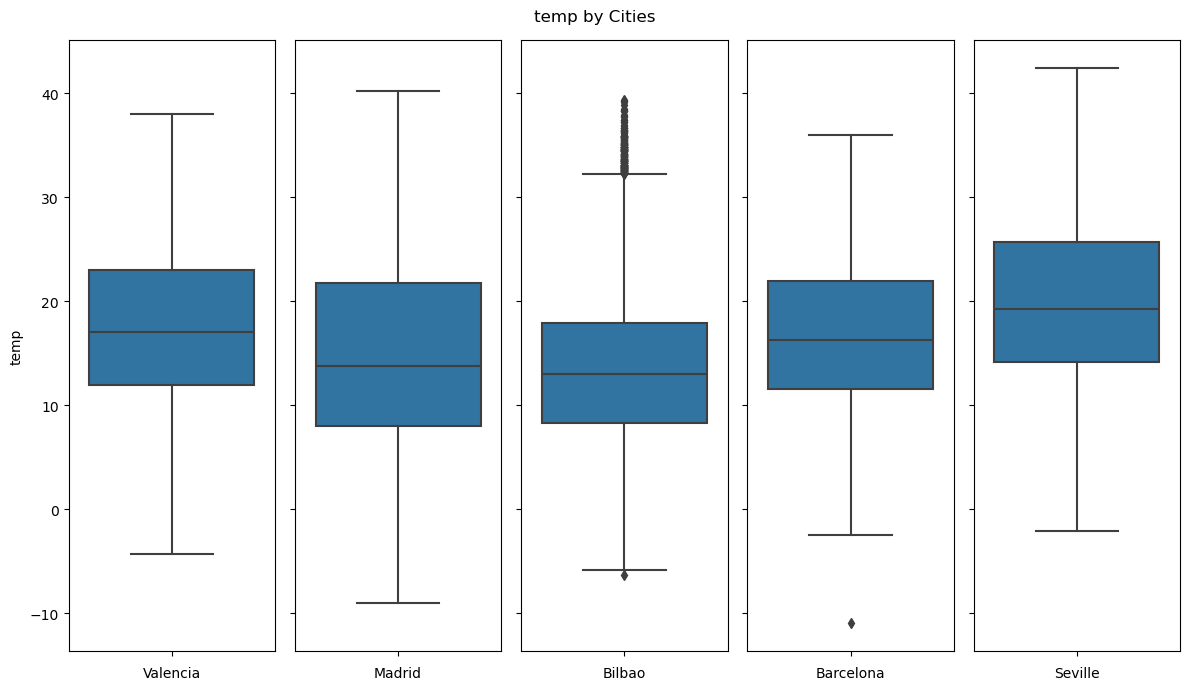

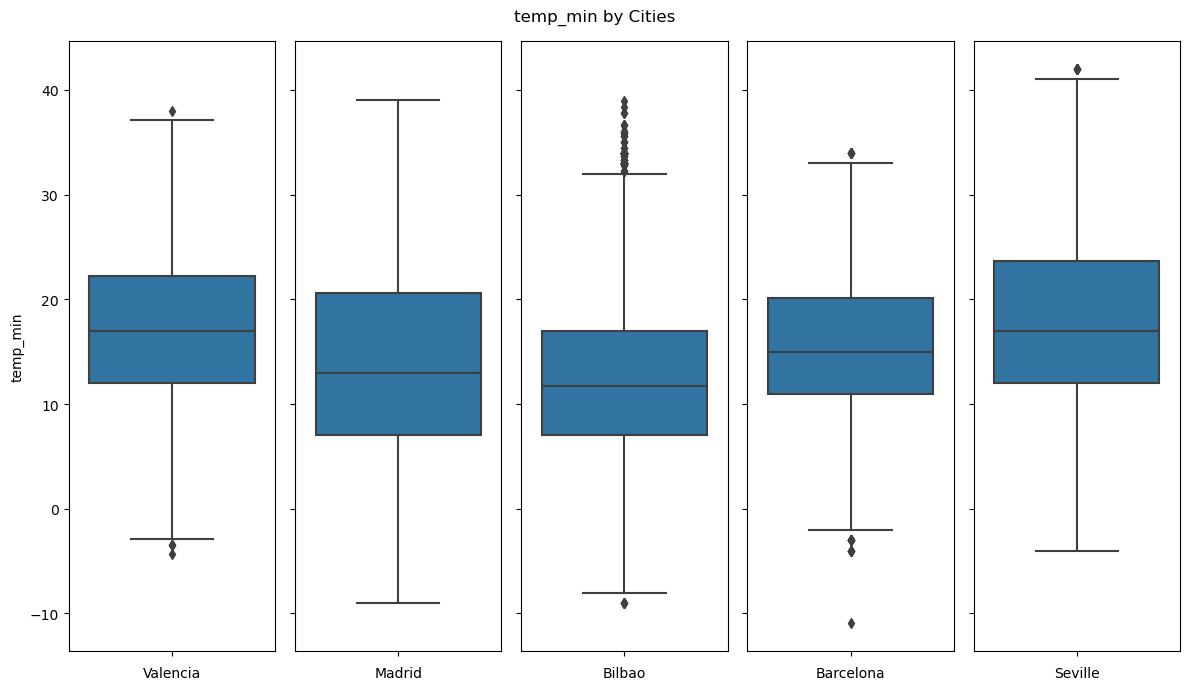

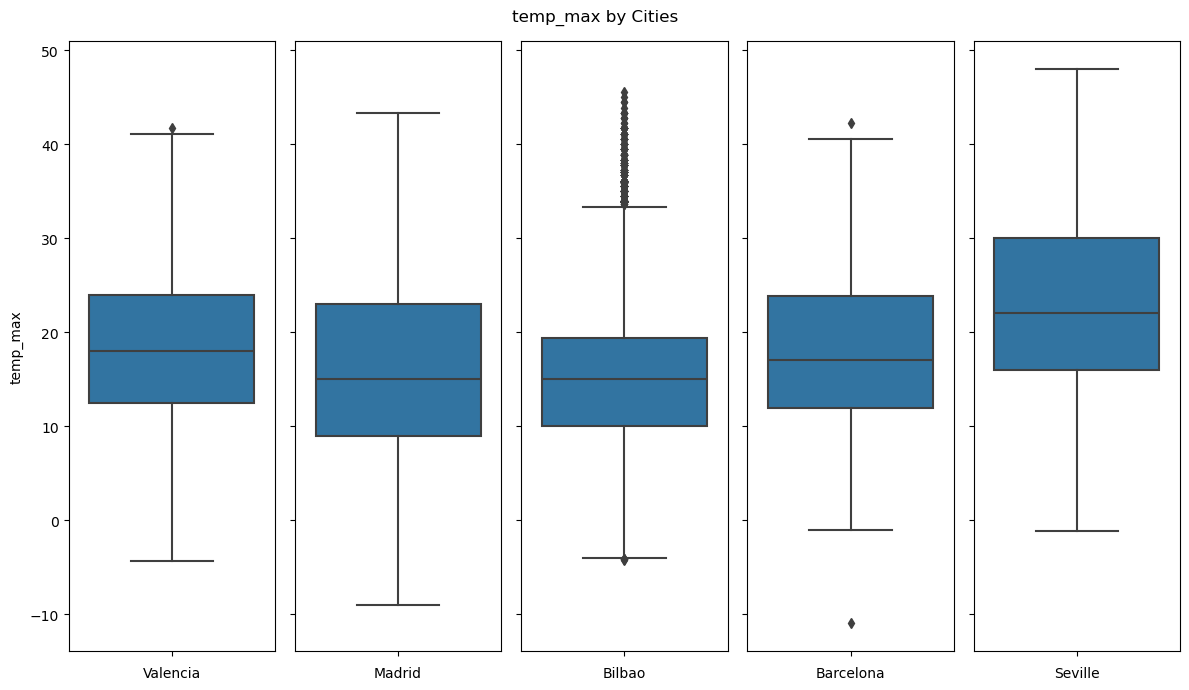

In [78]:
plot_city_comp_bp(df, "temp", cities)
plot_city_comp_bp(df, "temp_min", cities)
plot_city_comp_bp(df, "temp_max", cities)

Without considering the time factor:

**Seville** is generally the warmest city, both in terms of average temperatures and extremes. Its climate tends to be consistently hot throughout the year, making it stand out as the warmest among the cities examined. **Bilbao**, on the other hand, shows the most variability in temperatures, especially in maximum temperatures. This suggests that Bilbao experiences more extreme weather conditions compared to the other cities. **Valencia** and **Madrid** have similar temperature distributions, but Madrid exhibits slightly more variability in minimum temperatures. This indicates that Madrid may experience greater temperature swings than Valencia. **Barcelona** presents moderate temperature variability, with occasional cold spells. This results in a less extreme climate compared to the other cities.

Now considering the target variable:

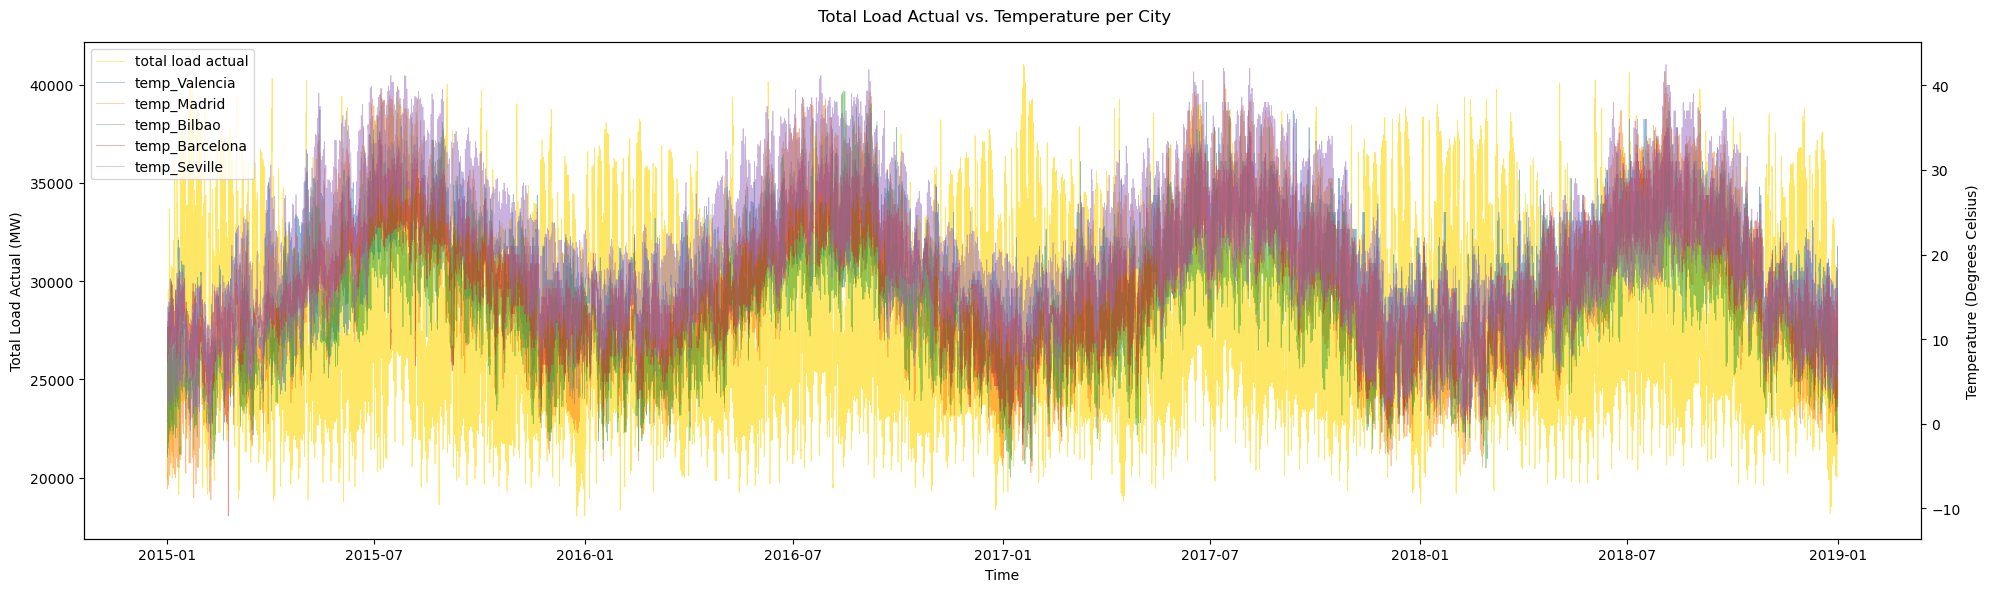

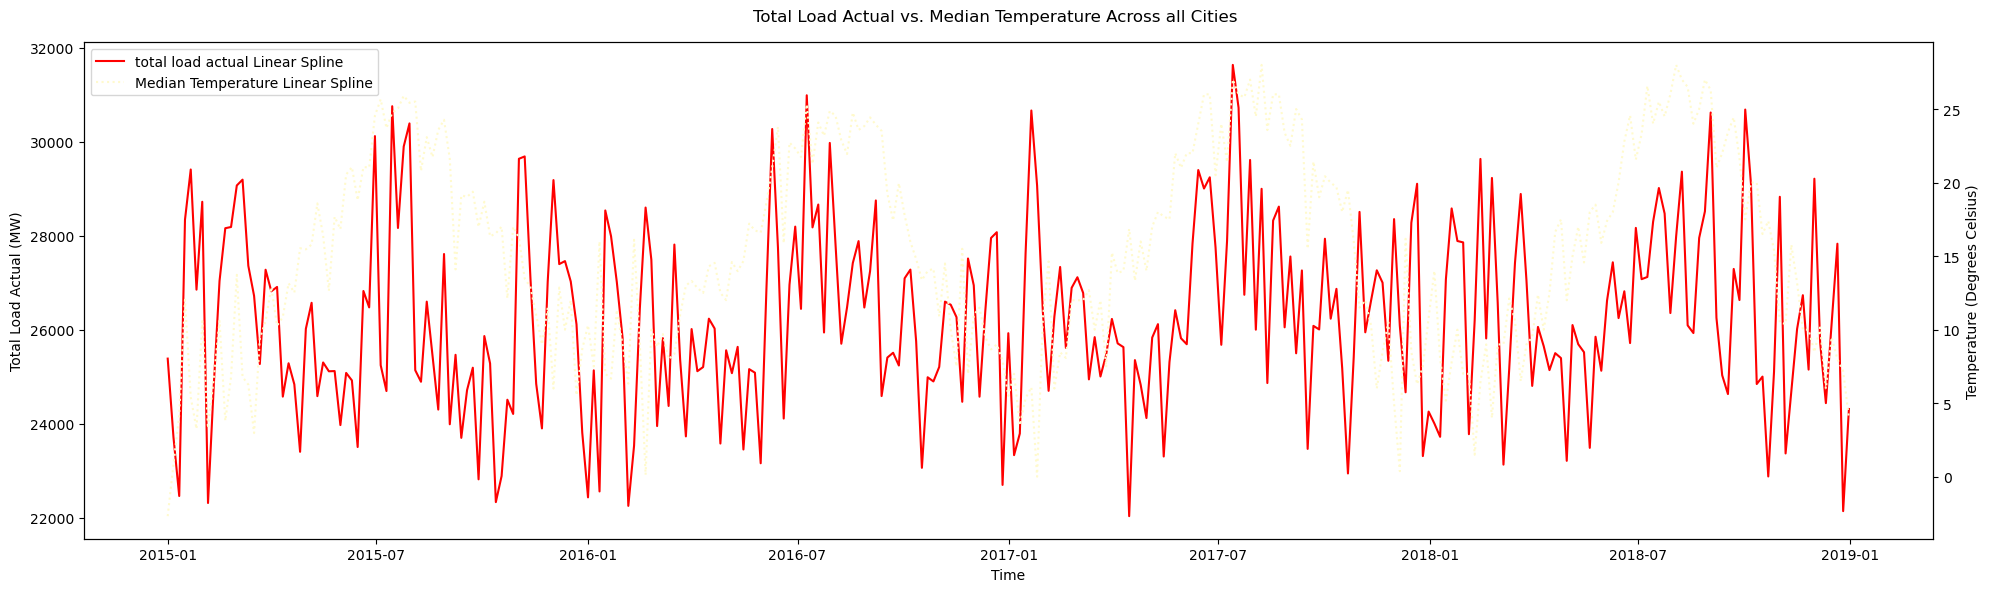

In [79]:
temp_by_city =  ['temp_Valencia', 'temp_Madrid', 'temp_Bilbao', 'temp_Barcelona', 'temp_Seville']
temp_df = df3[[TARGET] + temp_by_city].copy()
temp_df["Median Temperature"] = temp_df[temp_by_city].median(axis=1)
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Temperature (Degrees Celsius)":temp_by_city}, "Total Load Actual vs. Temperature per City")
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Temperature (Degrees Celsius)":["Median Temperature"]}, "Total Load Actual vs. Median Temperature Across all Cities", True, True)

The data reveals a clear relationship between temperature and Total Load Actual. During winter, when temperatures are low, and summer, when temperatures are high, Total Load Actual peaks. In contrast, during the fall and spring seasons, Total Load Actual is lower. This pattern is logical: people use more power for heating in cold weather and for air conditioning in hot weather. Demand spikes during extreme temperatures, such as summer heatwaves, while milder weather results in lower demand. Overall, there is strong seasonality in the temperature features across all cities.

Let's consider the average temperature in each city by season.

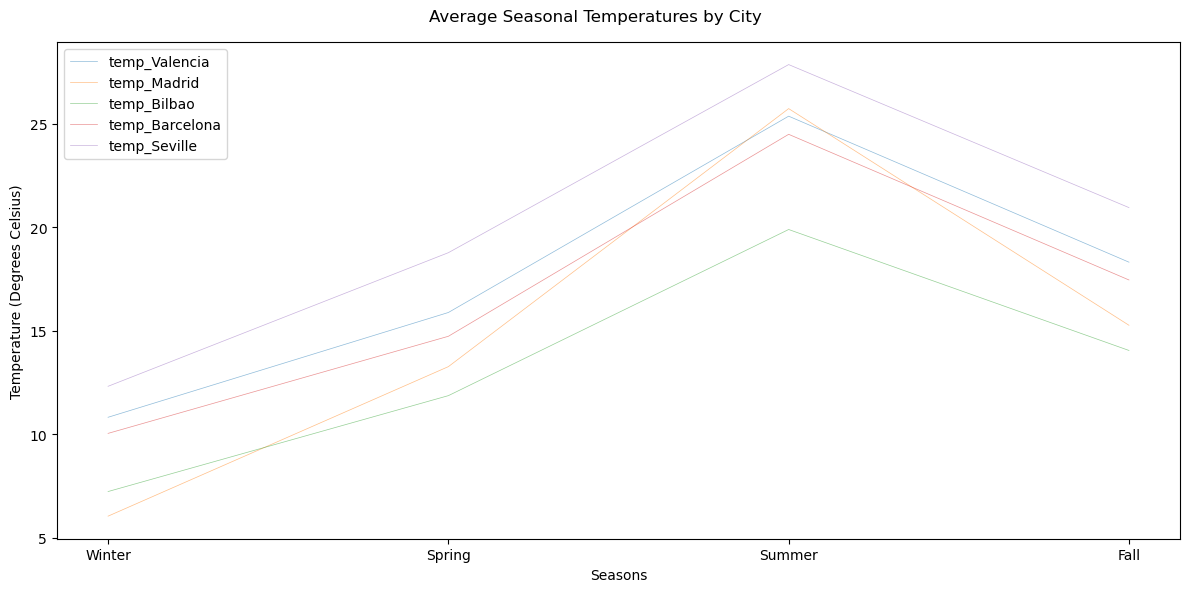

For Valencia, the number of large outliers per season:
Winter:10
Spring:17
Summer:1
Fall:37
*Valencia has a total of 65 large outliers.*
__________________________________________________________
For Madrid, the number of large outliers per season:
Winter:1
Spring:45
Summer:0
Fall:37
*Madrid has a total of 83 large outliers.*
__________________________________________________________
For Bilbao, the number of large outliers per season:
Winter:9
Spring:91
Summer:150
Fall:102
*Bilbao has a total of 352 large outliers.*
__________________________________________________________
For Barcelona, the number of large outliers per season:
Winter:9
Spring:26
Summer:3
Fall:17
*Barcelona has a total of 55 large outliers.*
__________________________________________________________
For Seville, the number of large outliers per season:
Winter:0
Spring:15
Summer:0
Fall:10
*Seville has a total of 25 large outliers.*
__________________________________________________________


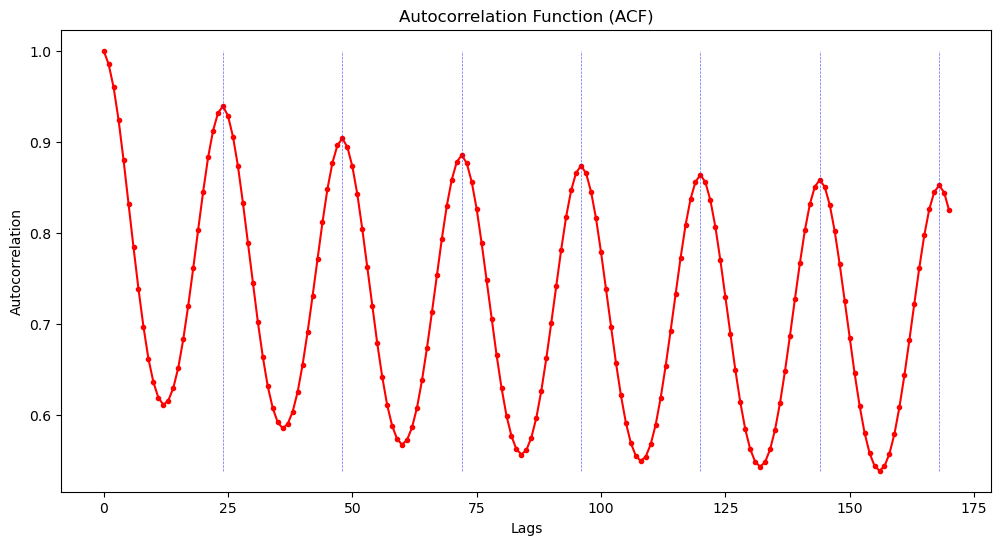

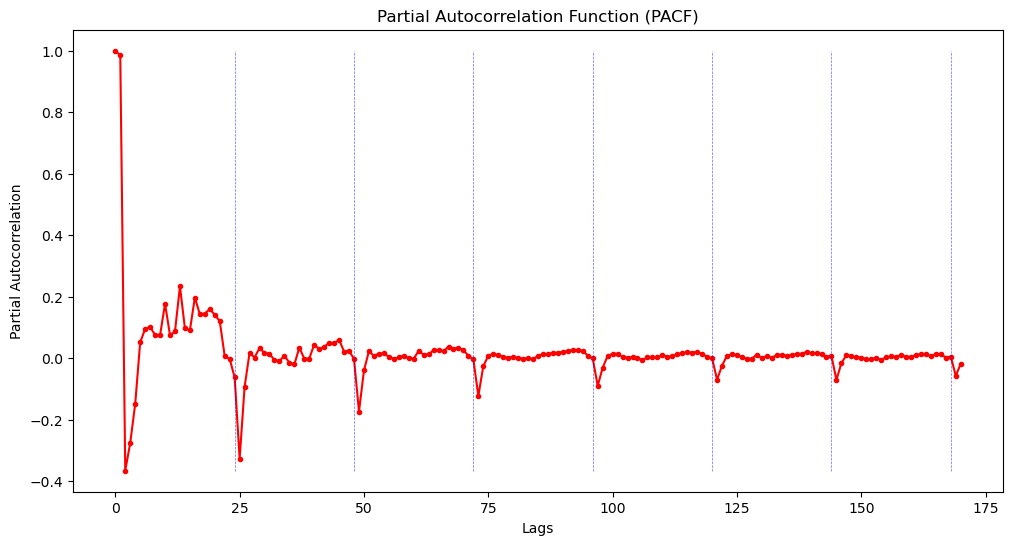

In [80]:
plot_average_feature_by_city(df3, temp_by_city, "Temperature (Degrees Celsius)", "Average Seasonal Temperatures by City")
temp = add_seasons(df.copy())
wf_count_outliers_by_cities(temp, cities, "temp", "season")
plot_wf_acf_pacf(df.copy(), "temp")

Based on the results above:

Introducing an hourly range, calculated as the difference between maximum and minimum temperatures (temp_max - temp_min), could be a valuable feature. This measure captures the variability in temperature throughout the day, and larger temperature ranges might indicate increased usage of air conditioning or heating systems. Additionally, incorporating time-based features such as the hour of the day, day of the week, and season or month can provide important context for the temperature data, aiding in the identification of patterns and trends. The ACF and PACF plots reveal strong seasonality at lag 24.

Given that weather varies with the seasons, and considering the results indicate that each city experiences a few outliers per season—especially with Bilbao showing particularly pronounced deviations, mainly due to extremely high temperatures—we should break down this feature by season to gain a better understanding of its impact.

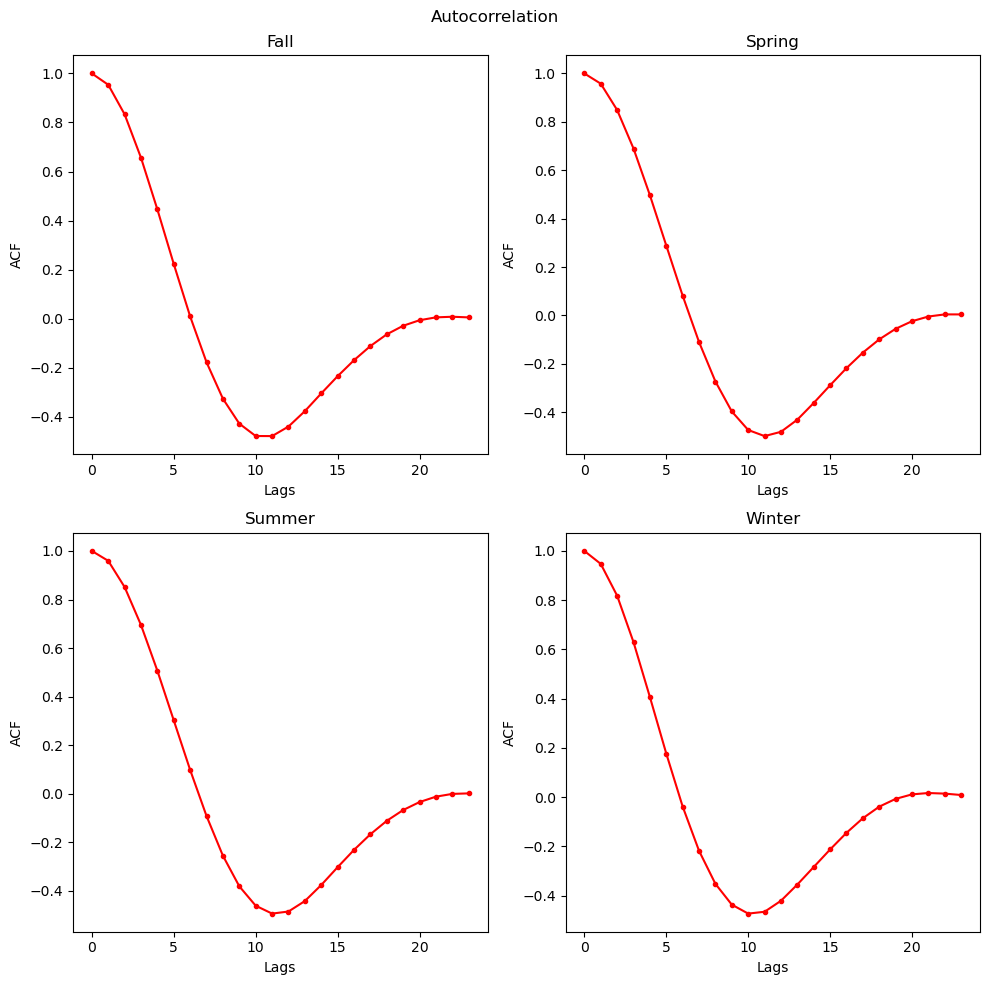

In [81]:
plot_wf_acf_pacf(df.copy(), "temp", nlags=24, time_groupby_list=["hour", "season"])

From the plots above, each season’s ACF plot shows steep drops in autocorrelation within the first five lags. This suggests that temperature quickly becomes uncorrelated over short time periods, likely due to the diurnal cycle. Since temperatures in each city are relatively consistent within each season, adding indicator features to detect anomalies is crucial, especially if these anomalies correspond to sudden spikes in electricity demand. Specifically, we should identify outliers by hour for each season.

**Source:**
- https://www.thoughtco.com/diurnal-temperature-range-3444244

## 3.2 Pressure

Atmospheric pressure influences weather patterns, which in turn significantly affects electricity demand. High-pressure systems typically bring clear, warm weather in summer, leading to increased use of air conditioning. In winter, high-pressure systems can result in clear, colder nights, raising heating demands. Conversely, low-pressure systems often bring cooler, cloudier conditions in summer, reducing the need for air conditioning, while in winter, they can lead to increased heating needs due to storms or cold fronts. Extreme weather events associated with rapid pressure changes can further strain the electricity grid, potentially causing outages or surges in demand as people use more energy to stay comfortable.

**Sources:**
- https://link.springer.com/article/10.1007/s11625-022-01219-7
- https://marketscale.com/industries/building-management/how-does-weather-affect-the-electrical-grid/
- https://www.masterclass.com/articles/how-barometric-pressure-works

Let's investigate this features and how it correlates with the target variable.

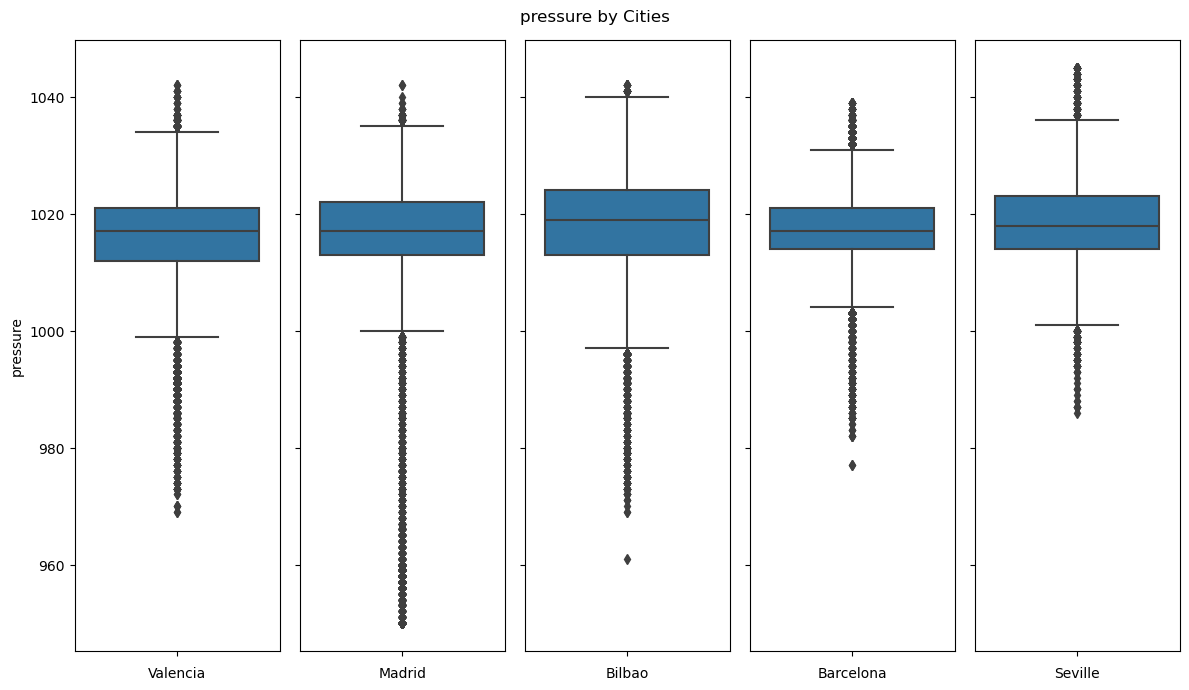

In [82]:
plot_city_comp_bp(df, "pressure", cities)

All cities display similar median pressure values around 1020 hPa, indicating consistent typical pressure across the locations. However, Madrid shows greater variability, with a more significant spread and a higher count of lower outliers, suggesting occasional significantly lower pressure events. While the overall pressure distributions are mostly symmetrical, a slight skew towards lower pressure values is present in most cities. Despite the outliers, the interquartile ranges remain relatively comparable, indicating that the core pressure data is stable across the cities.

Next, let's consider how pressure correlates with the target variable.

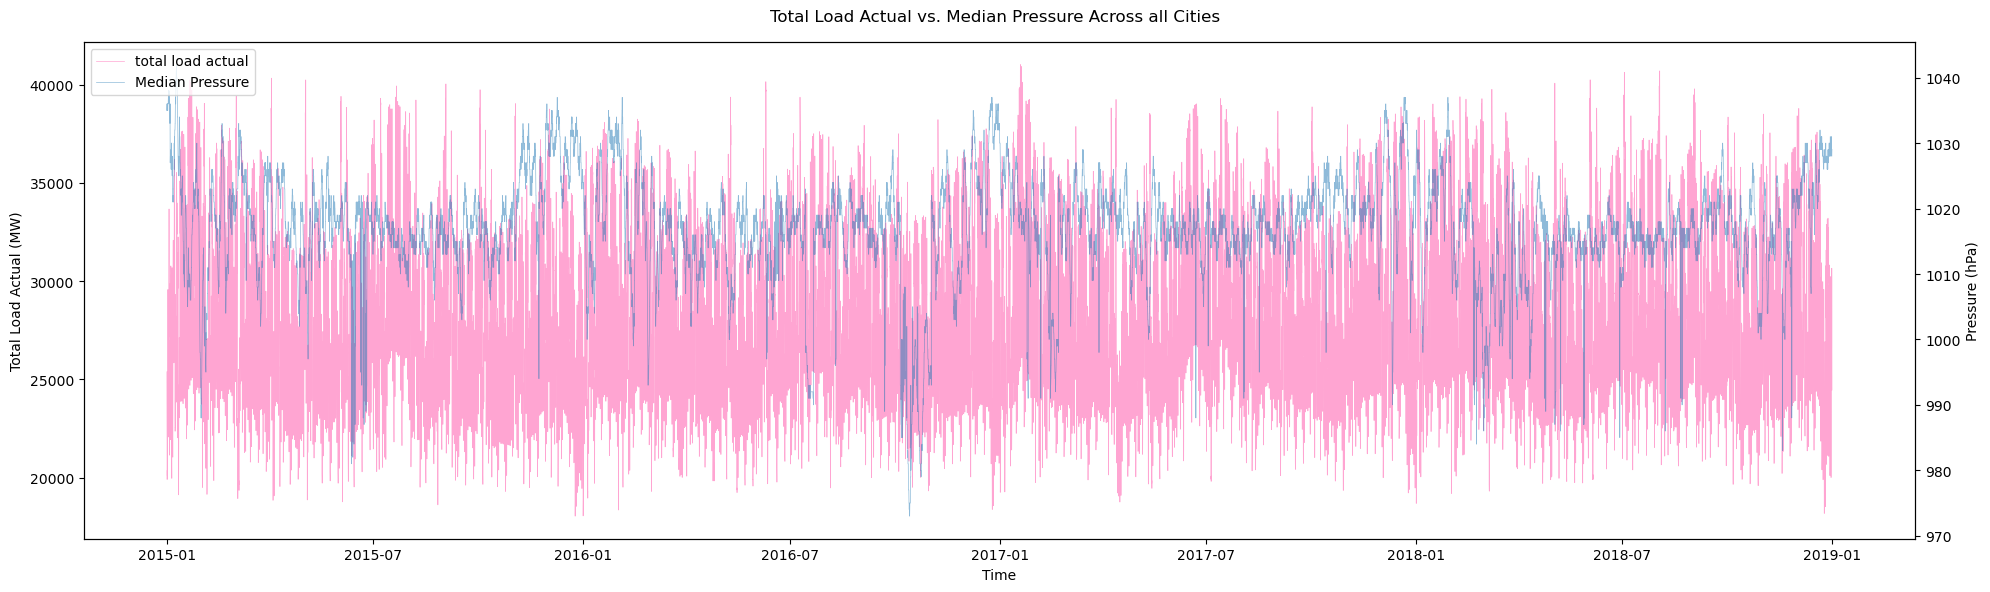

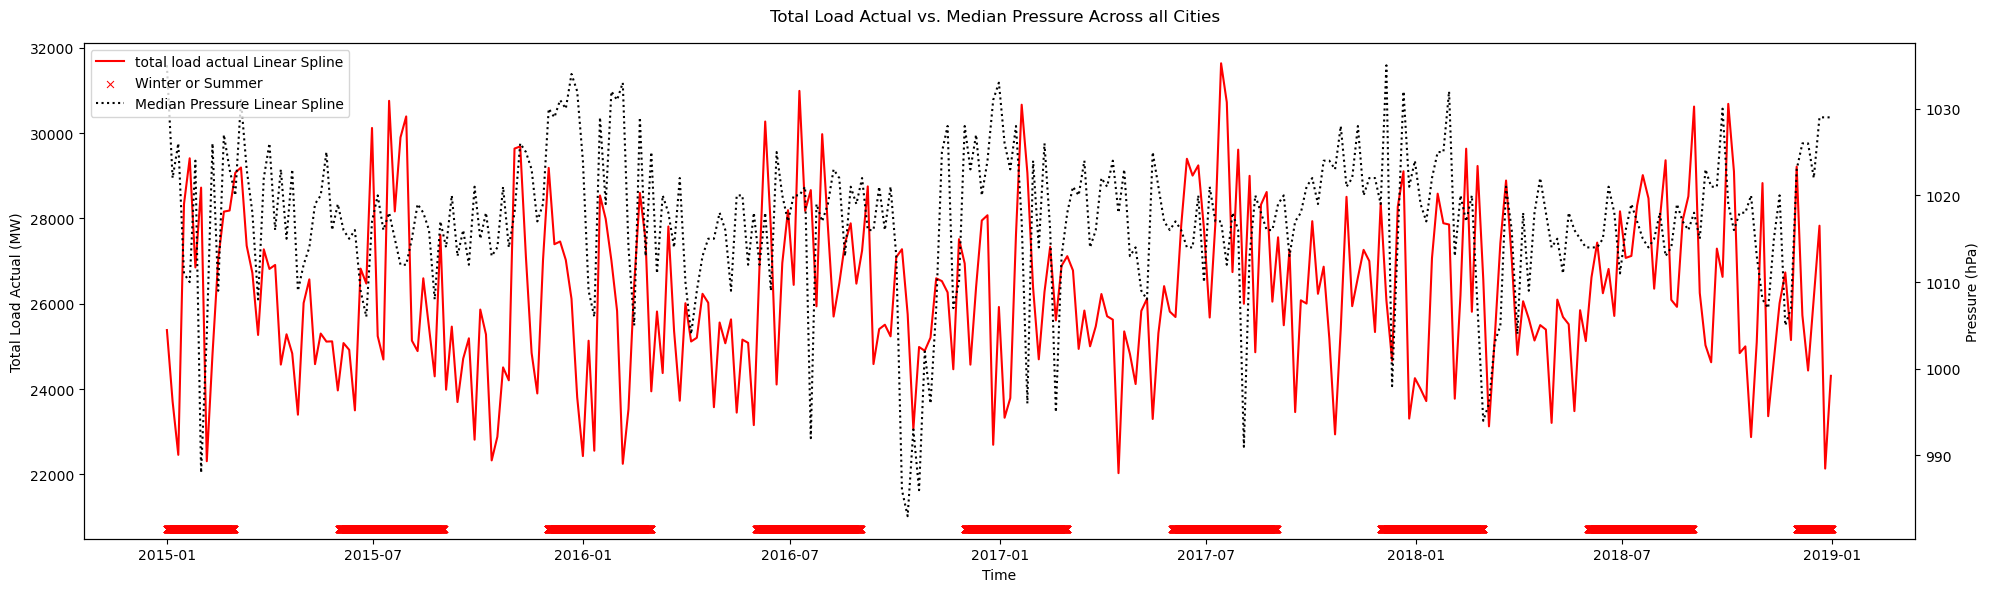

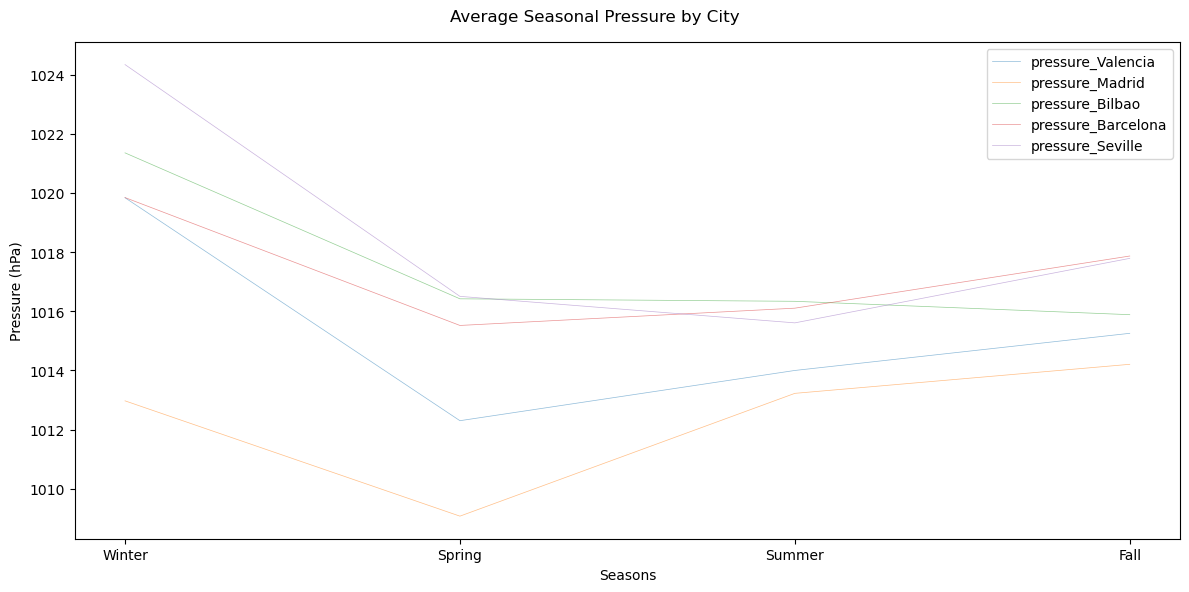

In [83]:
press_by_city =  ['pressure_Valencia', 'pressure_Madrid', 'pressure_Bilbao', 'pressure_Barcelona', 'pressure_Seville']
temp_df = df3[[TARGET] + press_by_city].copy()
temp_df["Median Pressure"] = temp_df[press_by_city].median(axis=1)
temp_df = add_seasons(temp_df)
plot_target_v_weather_pressure(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Pressure (hPa)":["Median Pressure"]}, "Total Load Actual vs. Median Pressure Across all Cities", lw2=1)
plot_target_v_weather_pressure(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Pressure (hPa)":["Median Pressure"]}, "Total Load Actual vs. Median Pressure Across all Cities", True, True)
plot_average_feature_by_city(df3, press_by_city, "Pressure (hPa)", "Average Seasonal Pressure by City")

The pressure trend across the visualizations remains relatively stable, typically fluctuating between 970 hPa and 1040 hPa over time. While pressure shows small, consistent variations, the total load displays much more dramatic fluctuations. Visual comparisons reveal occasional instances where increases in total load appear to coincide with decreases in pressure during winter and with increases in pressure during summer. However, no clear or consistent pattern emerges throughout the entire time series.


Let's look at the feature via ACF and PACF plots:

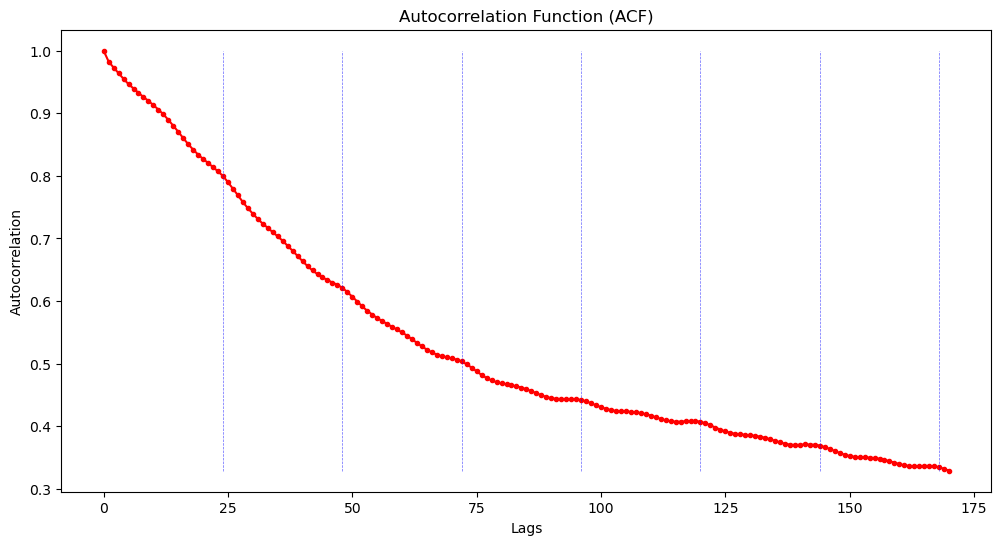

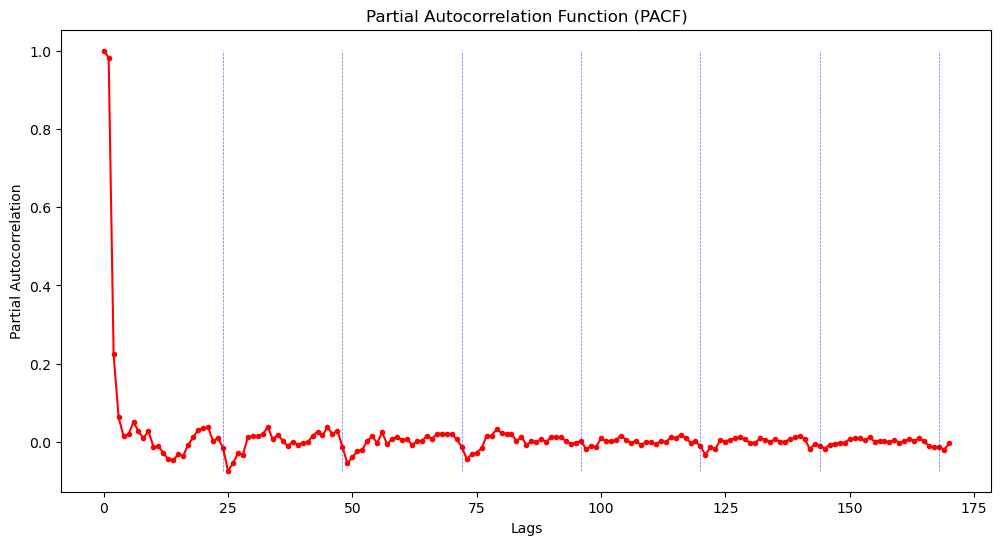

In [84]:
plot_wf_acf_pacf(temp_df, "Median Pressure")

The ACF and PACF plots do not indicate any seasonal trends but ACF show long-term dependencies.

Let's consider the ACF plots when we block the pressure feature by seasons. 

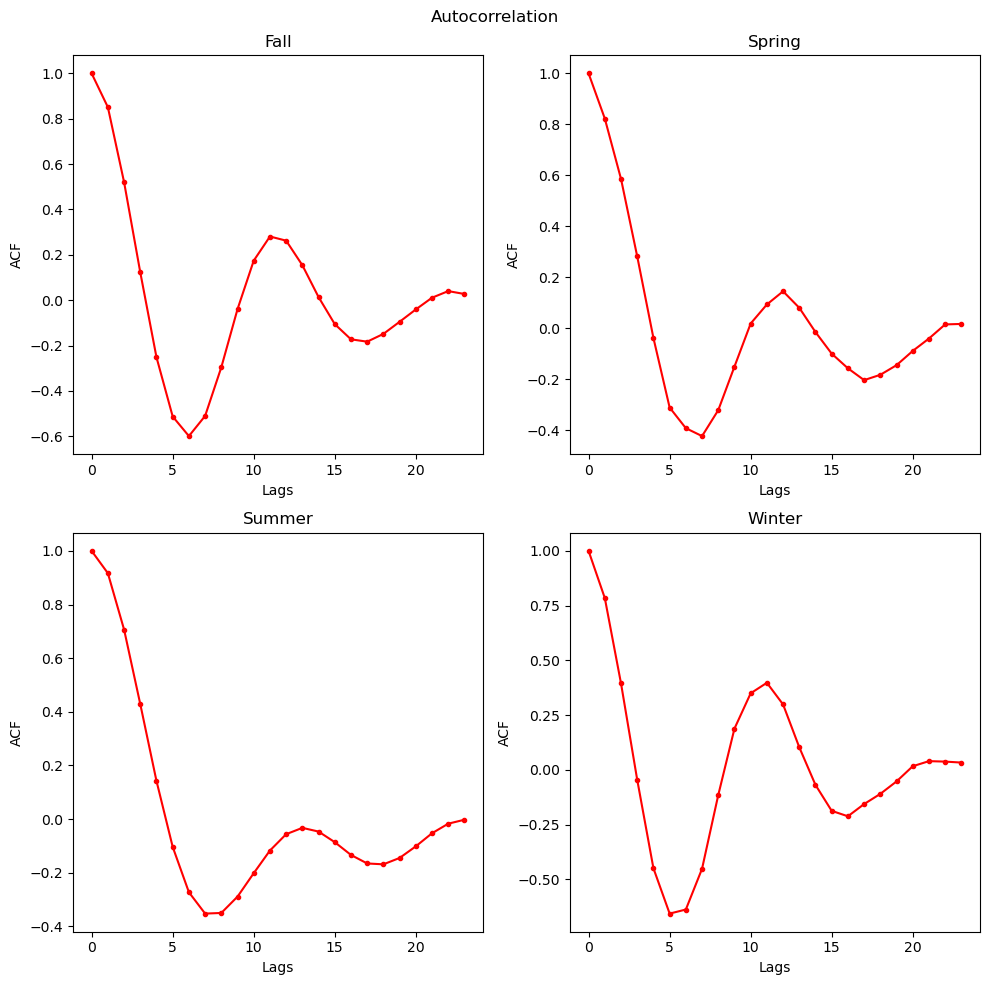

In [85]:
plot_wf_acf_pacf(df.copy(), "pressure", nlags=24, time_groupby_list=["hour", "season"])

From the ACF plots above, we observe a sharp drop in autocorrelation after a few lags, indicating that the relationship between pressure values weakens as the day progresses. The rise in ACF plots for Fall and Winter after the fifth lag might be related to day-night cycles. Despite observing several outliers, the lack of a clear consistent relationship between pressure and the target variable, introducing features to identify outliers by hour and season could be beneficial.

## 3.3 Humidity

Humidity makes people feel hotter, similar to temperature this most likely affects electirity demand by making people feel hotter. High humidity makes it harder for sweat to evaporate and cool the body, so even at lower temperatures, people may use more energy to dehumidify and cool indoor spaces.

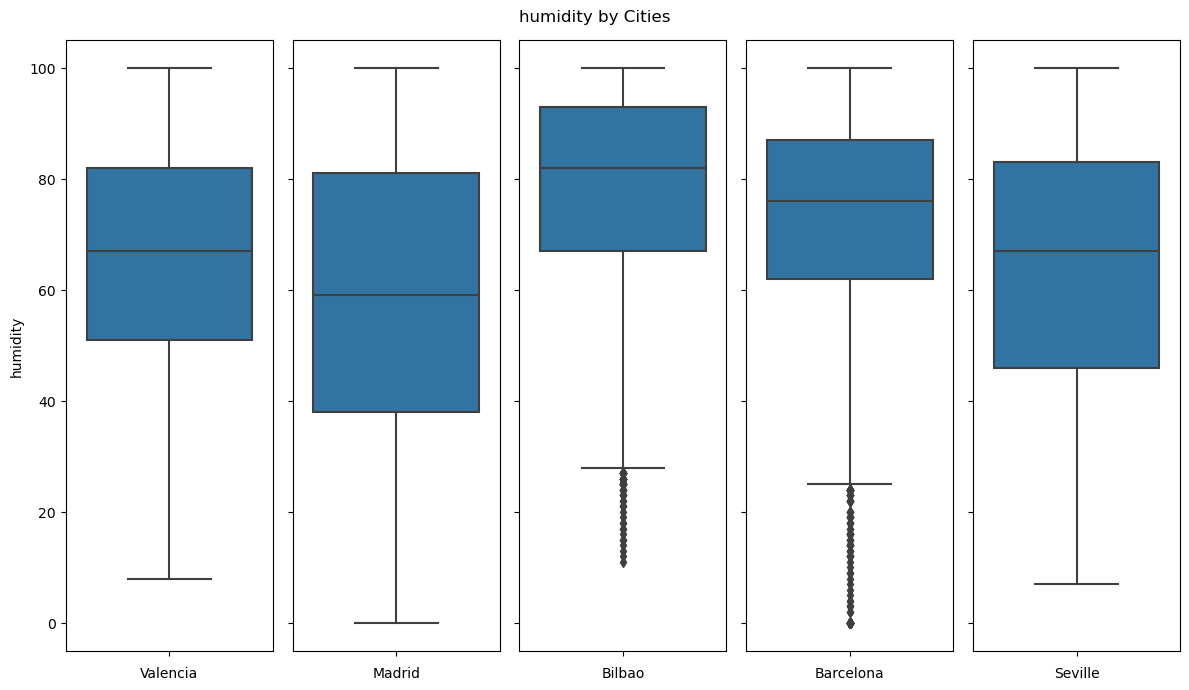

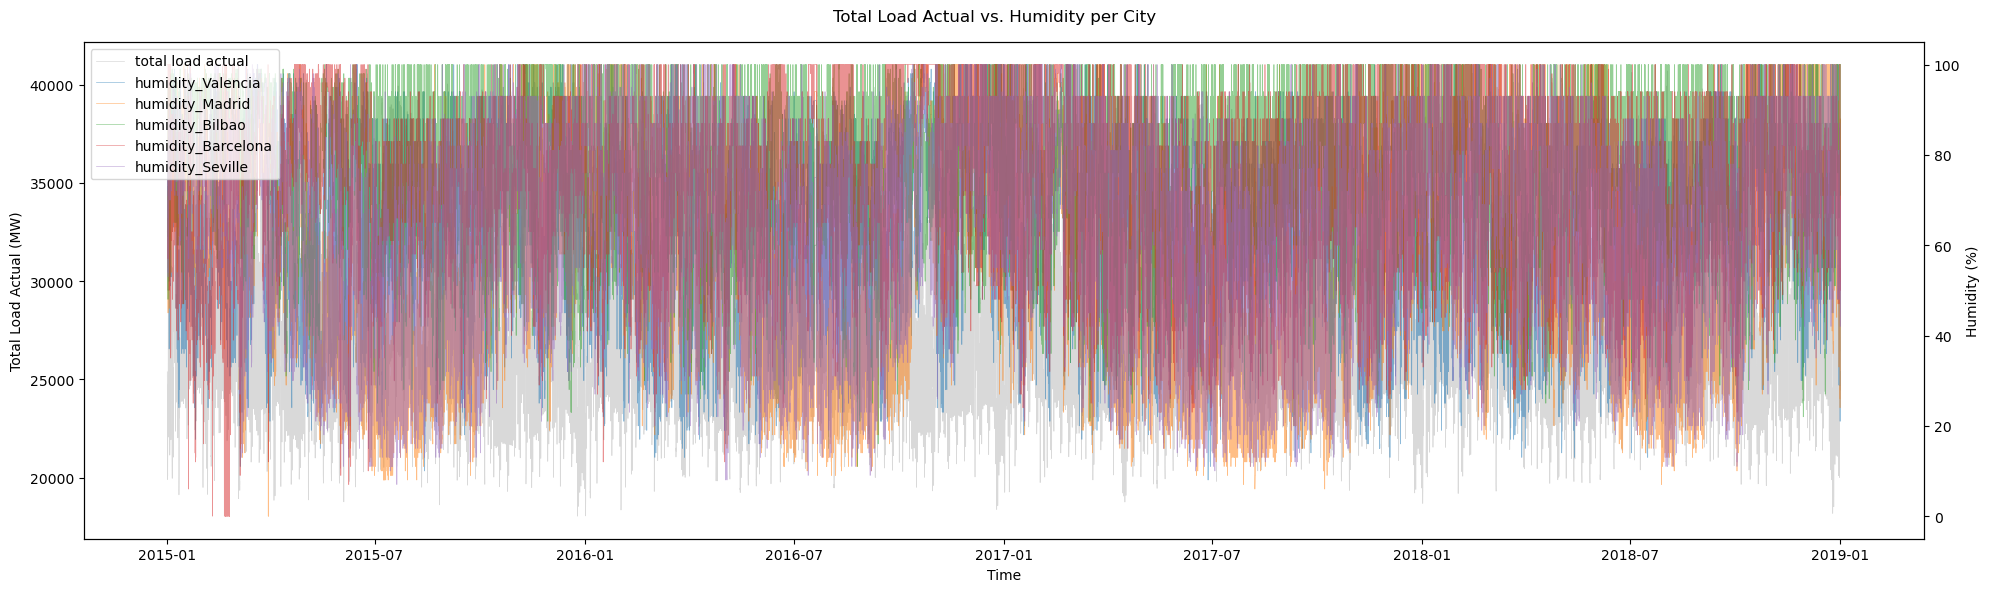

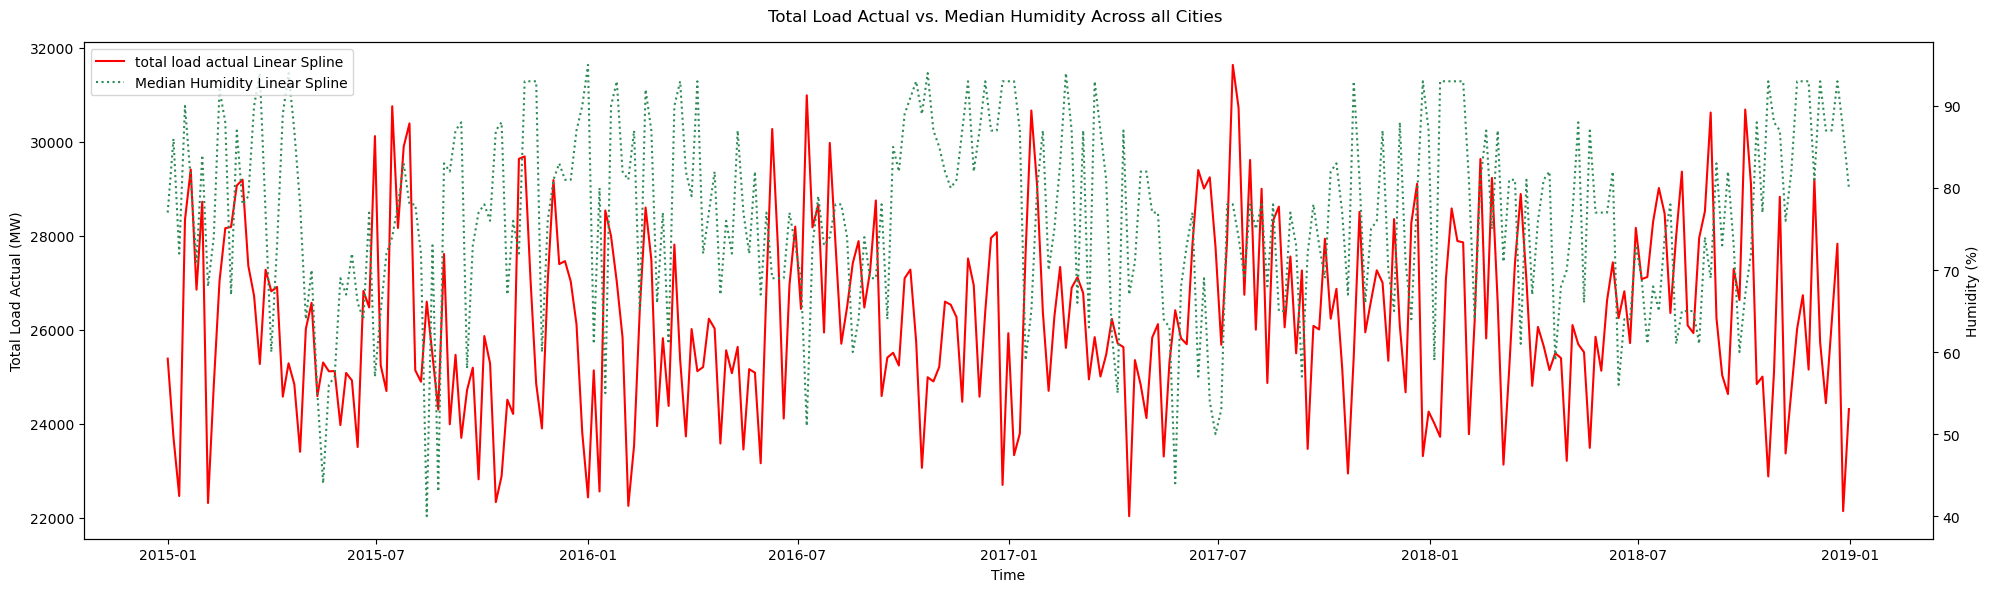

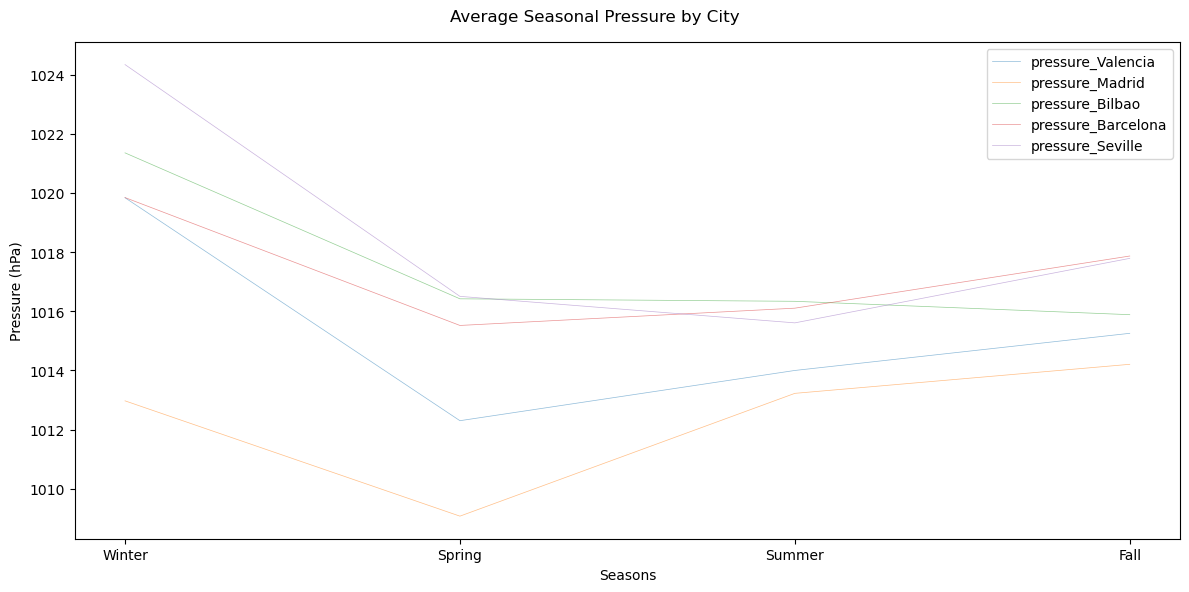

In [86]:
plot_city_comp_bp(df, "humidity", cities)

humid_by_city = ['humidity_Valencia', 'humidity_Madrid', 'humidity_Bilbao', 'humidity_Barcelona', 'humidity_Seville']
temp_df = df3[[TARGET] + humid_by_city].copy()
temp_df["Median Humidity"] = temp_df[humid_by_city].median(axis=1)
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Humidity (%)":humid_by_city}, "Total Load Actual vs. Humidity per City")
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Humidity (%)":["Median Humidity"]}, "Total Load Actual vs. Median Humidity Across all Cities", True, True)
plot_average_feature_by_city(df3, press_by_city, "Pressure (hPa)", "Average Seasonal Pressure by City")

The boxplots show Bilbao and Barcelona are the only two cities to display lower outliers across the timeseries.

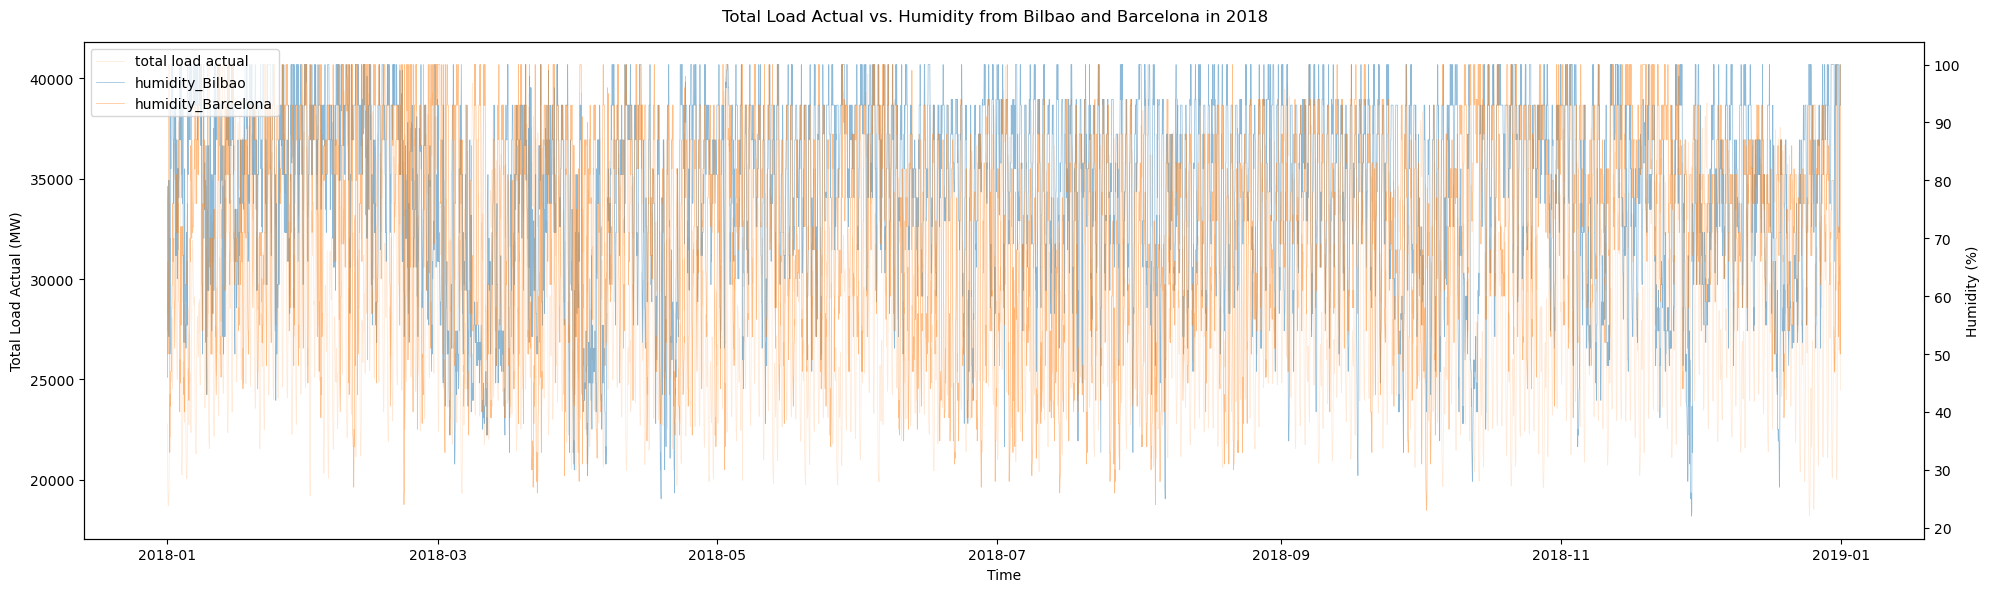

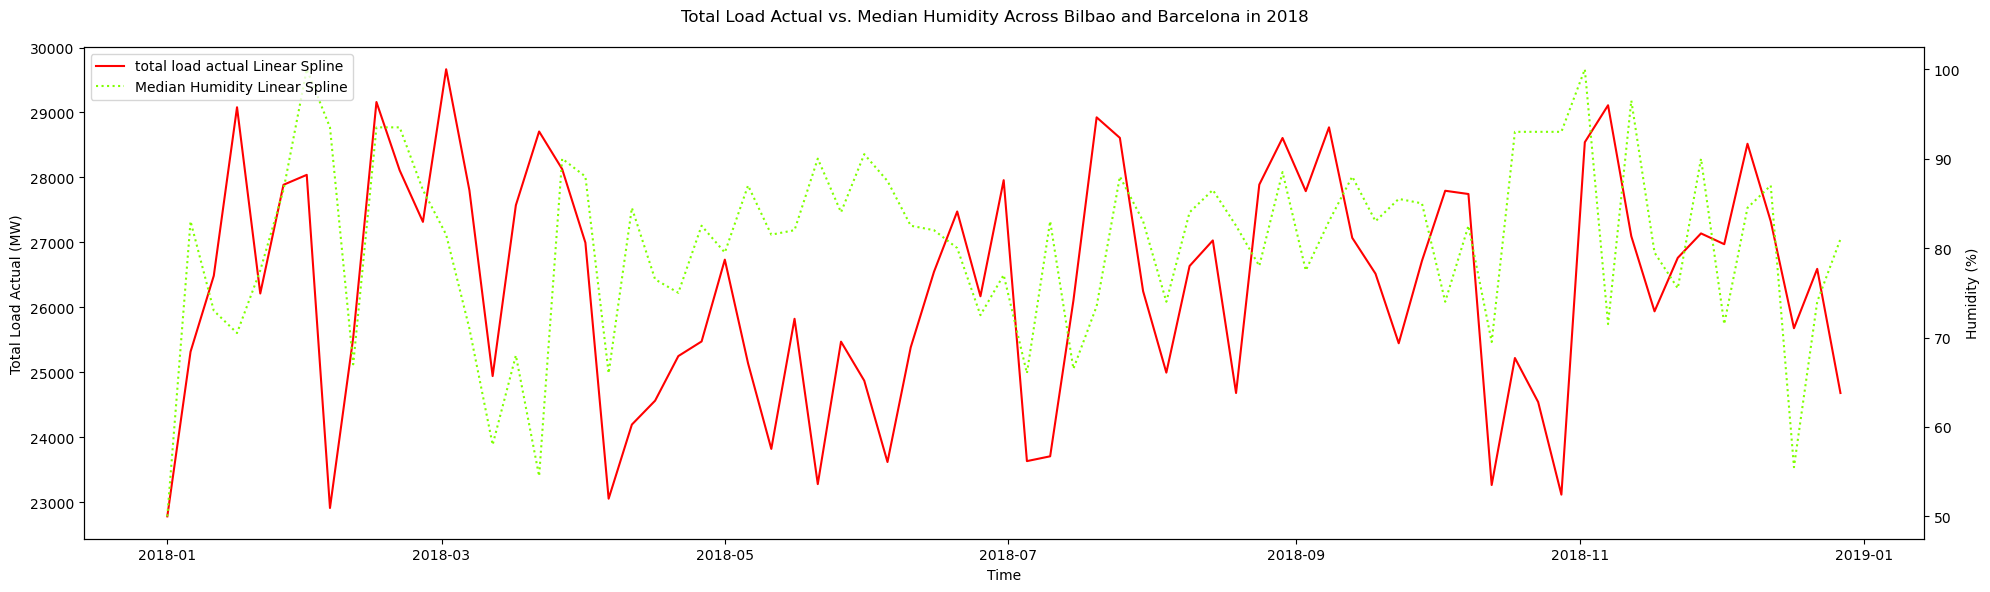

In [87]:
humid_by_city = ['humidity_Bilbao', 'humidity_Barcelona']
temp_df2 = df3[[TARGET] + humid_by_city].copy()
temp_df2 = temp_df2[temp_df2.index.year.isin([2018])]
temp_df2["Median Humidity"] = temp_df2[humid_by_city].median(axis=1)
plot_target_v_weather(temp_df2, {"Total Load Actual (MW)":[TARGET]}, {"Humidity (%)":humid_by_city}, "Total Load Actual vs. Humidity from Bilbao and Barcelona in 2018")
plot_target_v_weather(temp_df2, {"Total Load Actual (MW)":[TARGET]}, {"Humidity (%)":["Median Humidity"]}, "Total Load Actual vs. Median Humidity Across Bilbao and Barcelona in 2018", True, True)

The results indicate that coastal cities, such as Barcelona and Bilbao, generally maintain consistently high humidity levels. In contrast, inland cities like Seville and Madrid exhibit greater variation in humidity. Although Valencia is also a coastal city, its humidity levels are more stable compared to Barcelona and Bilbao. This stability can be attributed to Valencia's geographical and topographical features. Barcelona, surrounded by the Collserola mountain range, tends to trap dry inland air, leading to more variable humidity. Similarly, Bilbao, influenced by the Cantabrian Mountains and the Atlantic Ocean, experiences fluctuating humidity levels. In contrast, Valencia's open coastline and absence of significant nearby mountains contribute to more consistent humidity throughout the year.

**Sources:**
- https://www.barcelonacity.com/v/geography/
- https://luxurytraveldiva.com/is-the-climate-of-barcelona-dry-or-wet/
- https://www.easyexpat.com/en/guides/spain/barcelona/overview/geography.htm

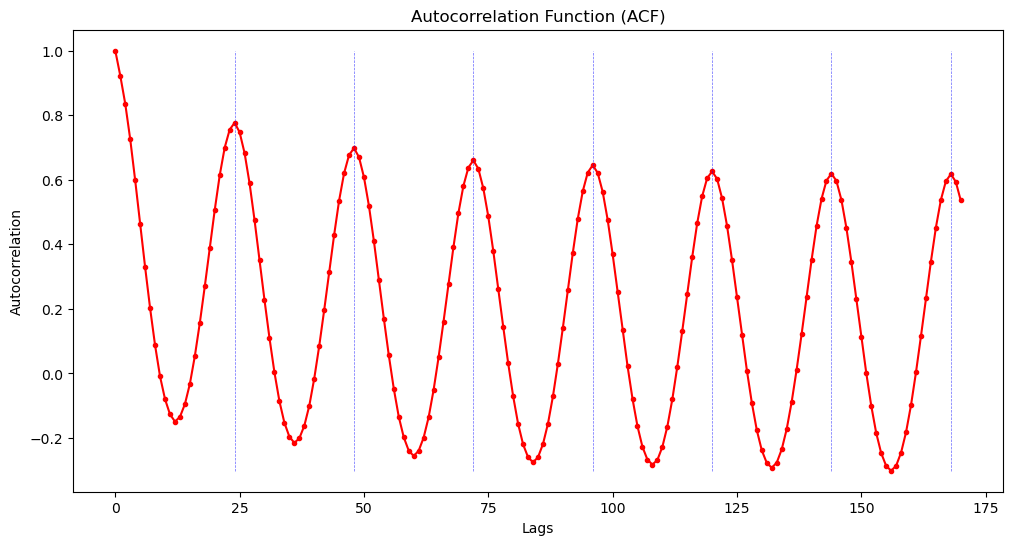

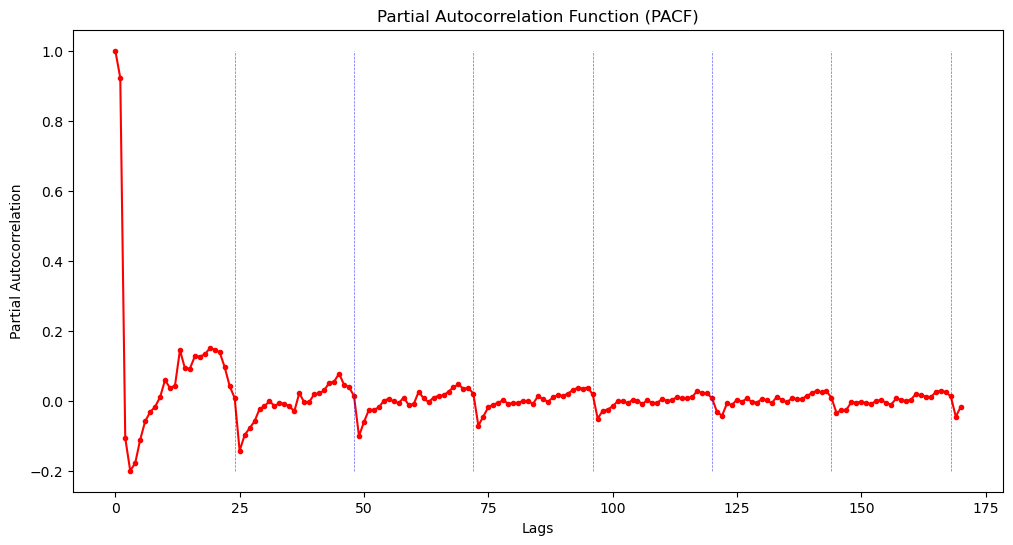

In [88]:
plot_wf_acf_pacf(temp_df, "Median Humidity")

The ACF and PACF plots for the humidity feature across the entire time series show a pattern similar to that of temperature, indicating strong seasonality. However, unlike the temperature feature, the humidity feature does not exhibit a clear relationship with the target variable. The cycles in humidity and electricity load do not align perfectly, suggesting that their relationship may not be immediate or direct.

Let's consider the interaction between temperature and humidity, and the potential impact they have together on the target variable.

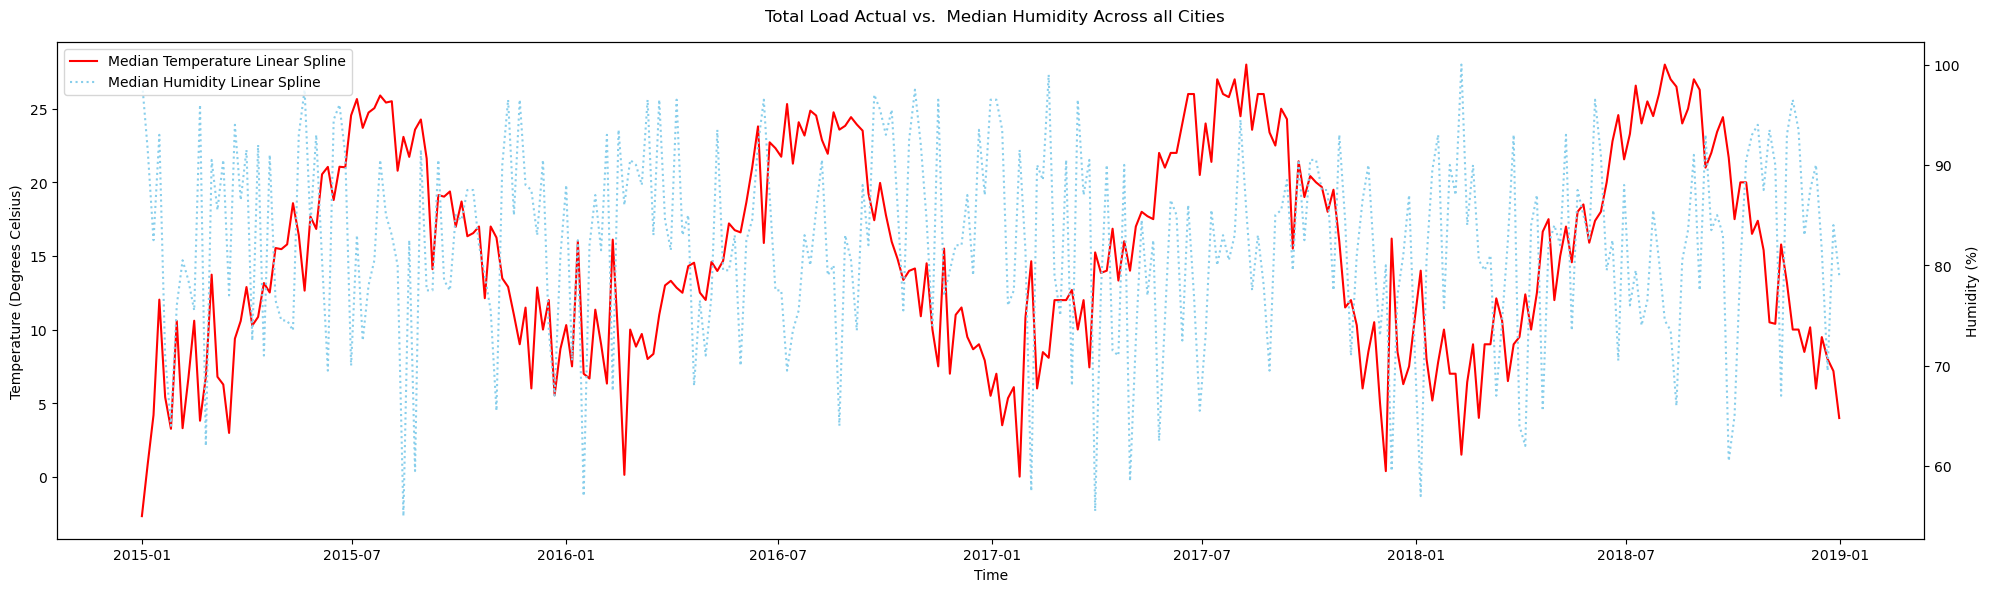

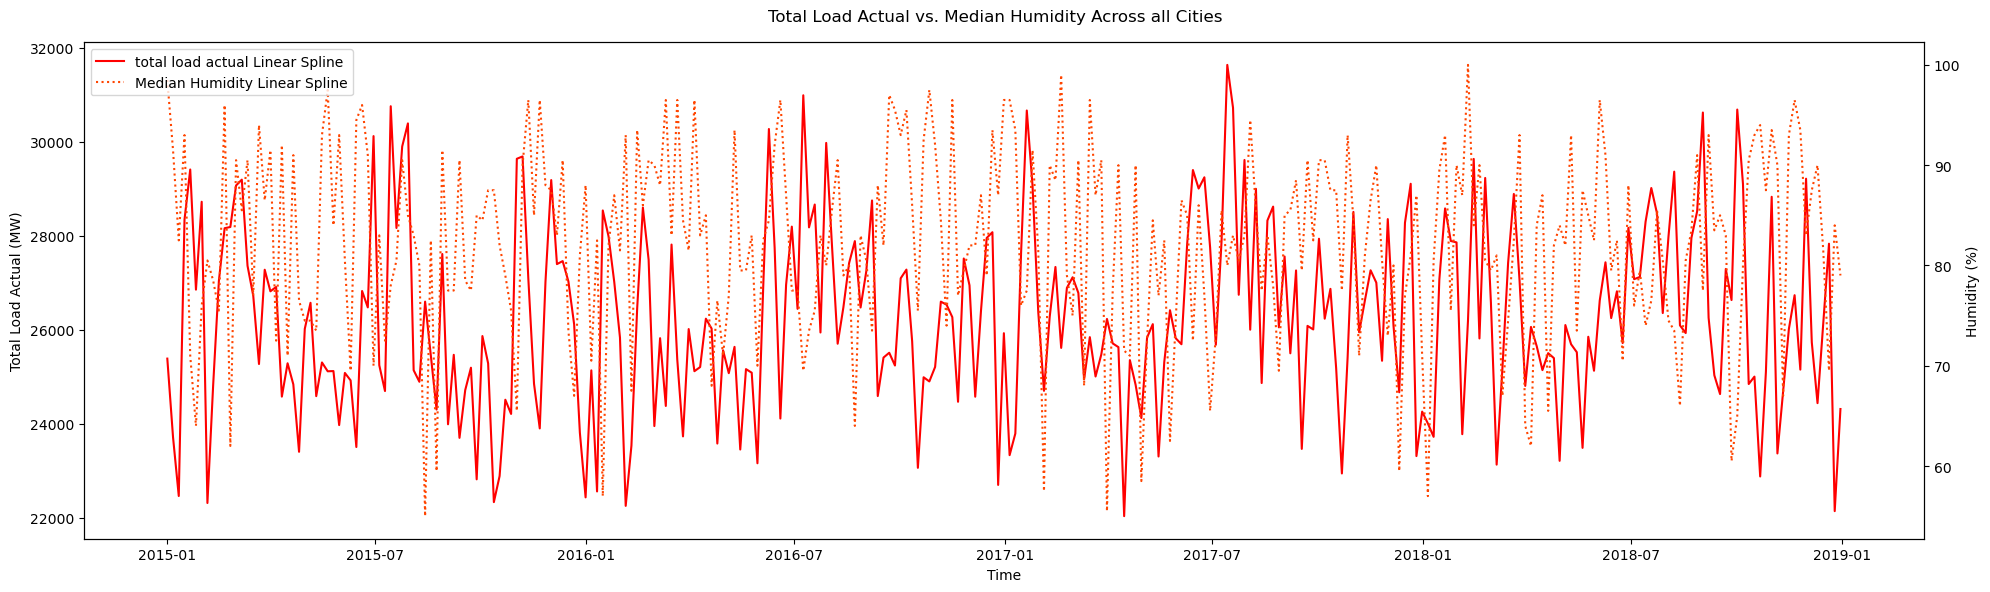

In [90]:
temp_df3 = df3[[TARGET] + temp_by_city + humid_by_city].copy()
temp_df3["Median Temperature"] = temp_df3[temp_by_city].median(axis=1)
temp_df3["Median Humidity"] = temp_df3[humid_by_city].median(axis=1)
temp_df3["Median Humidity Lag 24"] = temp_df3["Median Humidity"].shift(24)
plot_target_v_weather(temp_df3, {"Temperature (Degrees Celsius)":["Median Temperature"]}, {"Humidity (%)":["Median Humidity"]}, "Total Load Actual vs.  Median Humidity Across all Cities", True, True)
plot_target_v_weather(temp_df3, {"Total Load Actual (MW)":[TARGET]}, {"Humidity (%)":["Median Humidity"]}, "Total Load Actual vs. Median Humidity Across all Cities", True, True)

From the plots above, there appears to be a potential interaction between temperature and humidity that may significantly influence the target variable. While temperature is the primary driver affecting the target variable, humidity seems to act as an "enhancer," increasing the need for cooling or heating, particularly during hot and humid summers or cold and damp winters. Together, these features could explain much of the variability in the target variable, especially during seasonal peaks.


Next let's consider the ACF plots when we block the humidity feature by seasons.

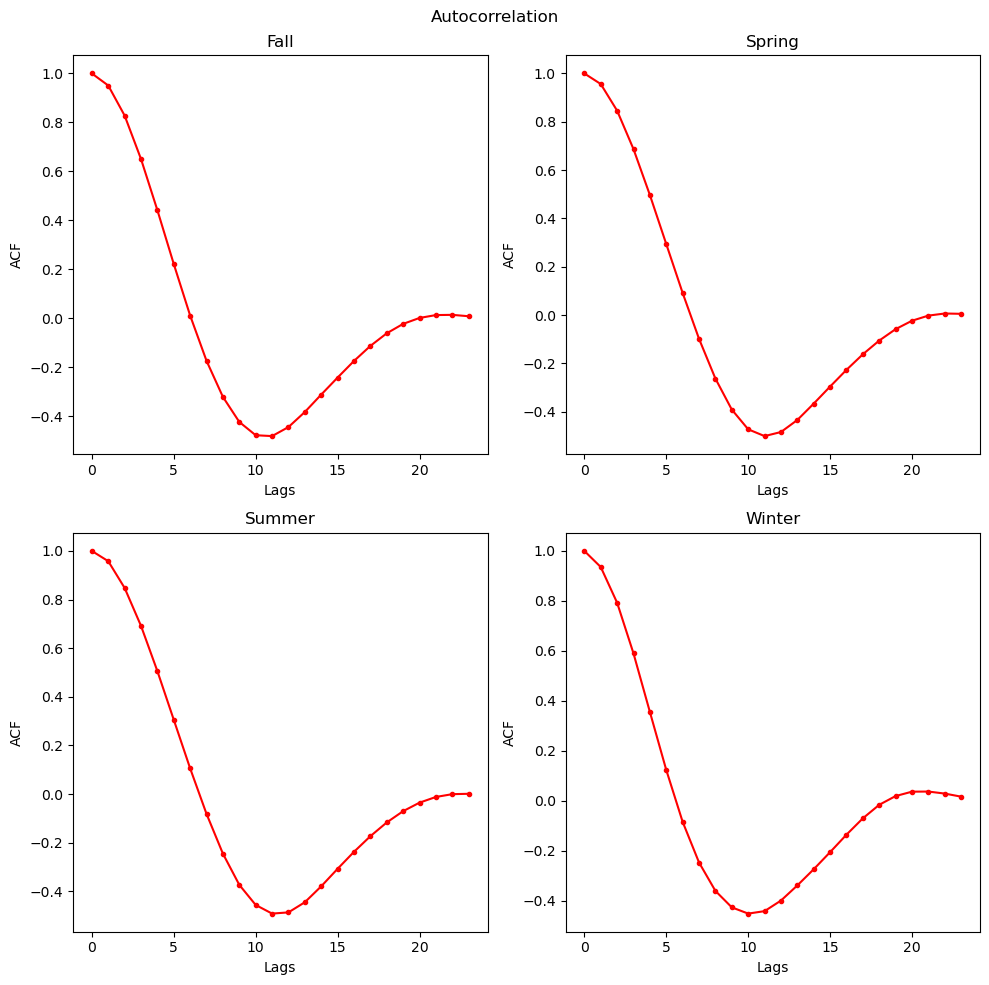

In [91]:
plot_wf_acf_pacf(df.copy(), "humidity", nlags=24, time_groupby_list=["hour", "season"])

In [92]:
temp = df.copy()
temp = add_seasons(temp)
x = temp.loc[find_outliers(temp[temp["city_name"]=="Barcelona"]["humidity"]).index]["season"].value_counts()
y = temp.loc[find_outliers(temp[temp["city_name"]=="Bilbao"]["humidity"]).index]["season"].value_counts()
pd.merge(x.to_frame(name="Barcelona Outliers"), y.to_frame(name="Bilbao Outliers"), left_index=True, right_index=True, how="outer").T

season              Fall  Spring  Summer  Winter
Barcelona Outliers    25      85     100     550
Bilbao Outliers      105      75     110      30

While there are outliers in humidity levels—such as the lower humidity observed in Bilbao and Barcelona, which could be linked to colder weather—these are unlikely to significantly impact electricity usage. From the ACF and PACF plots by season, similar to the features above, they all display a sharp drop in autocorrelation, implying humidity becomes uncorrelated over short time periods. Nonetheless, we will introduce indicators to detect humidity outliers per city, even though these outliers are not expected to be major drivers of electricity demand.

## 3.3 Snowfall Feature

Based on our understanding, snowfall likely has a direct impact on the target variable. Snowfall is typically associated with colder temperatures, which, as observed, have a clear relationship with the target variable. We would therefore expect that increased snowfall leads to higher heating demand, potentially resulting in an increase in the total actual load.

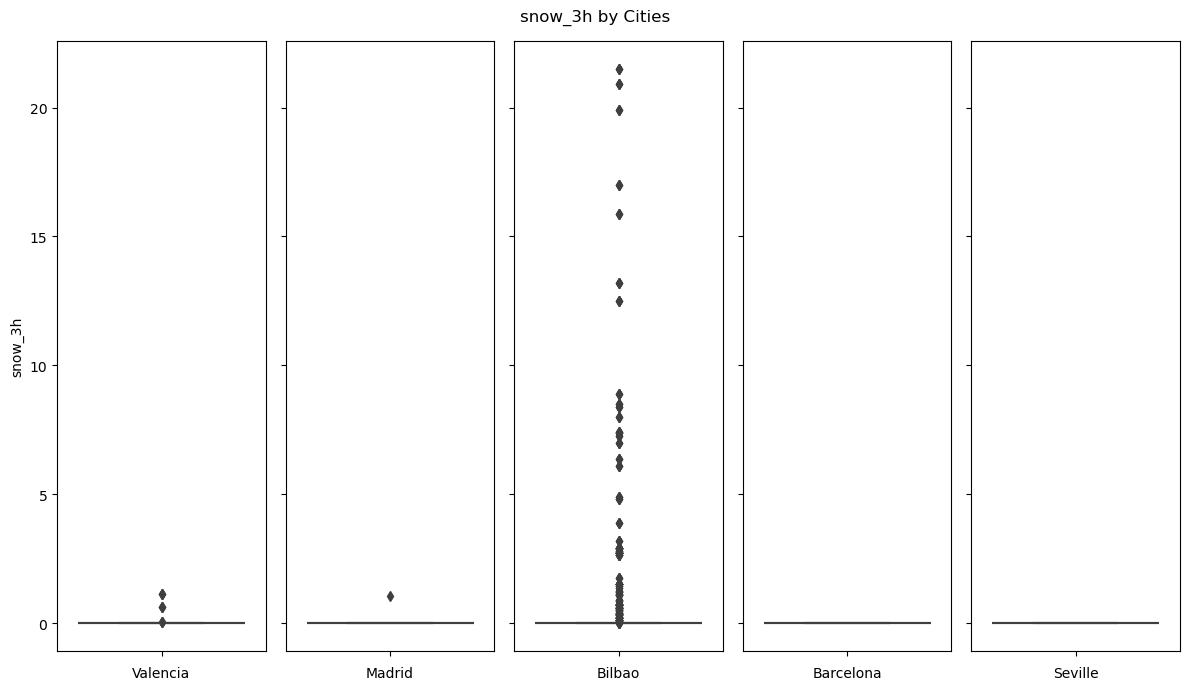

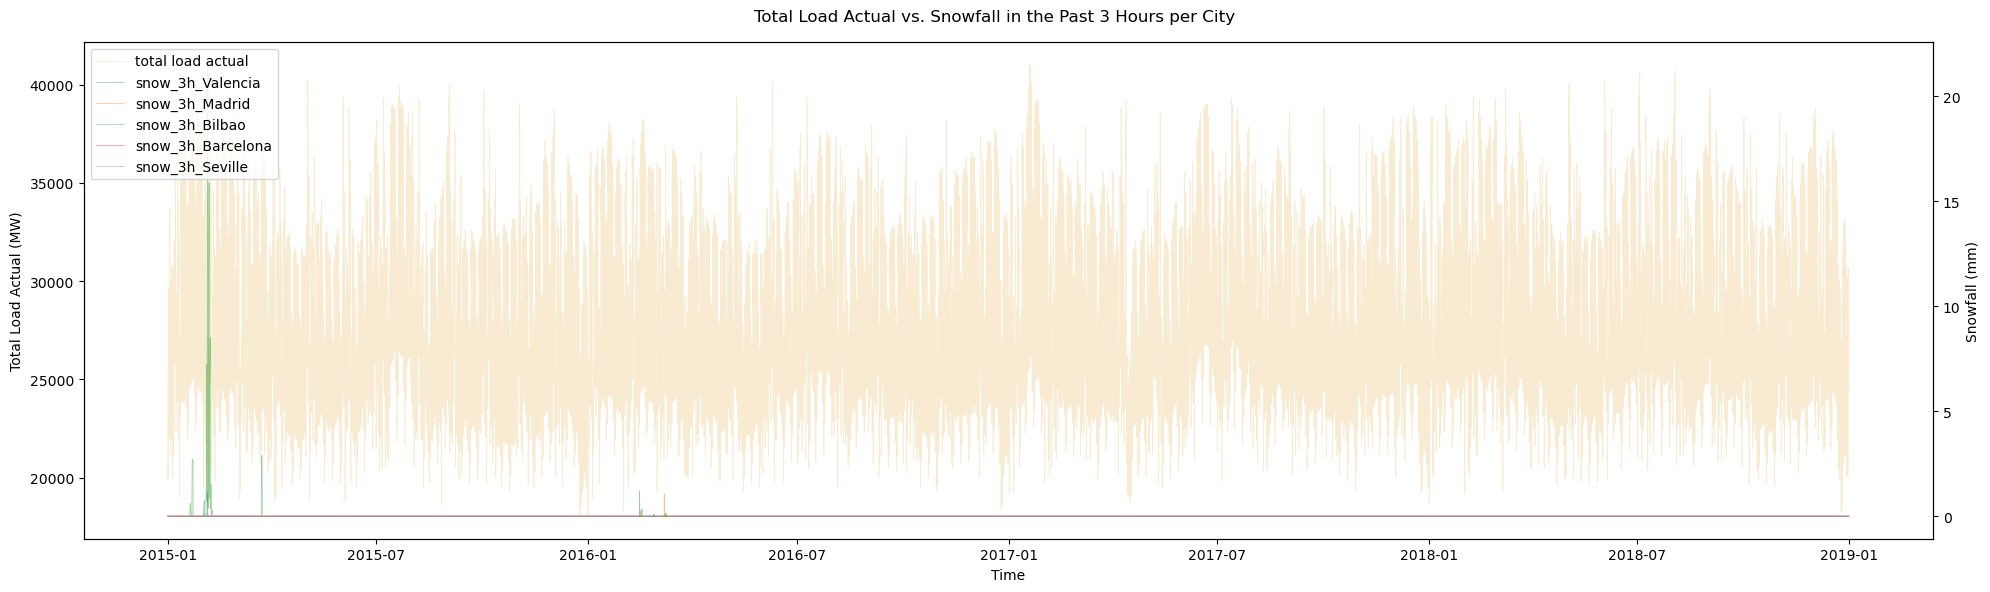

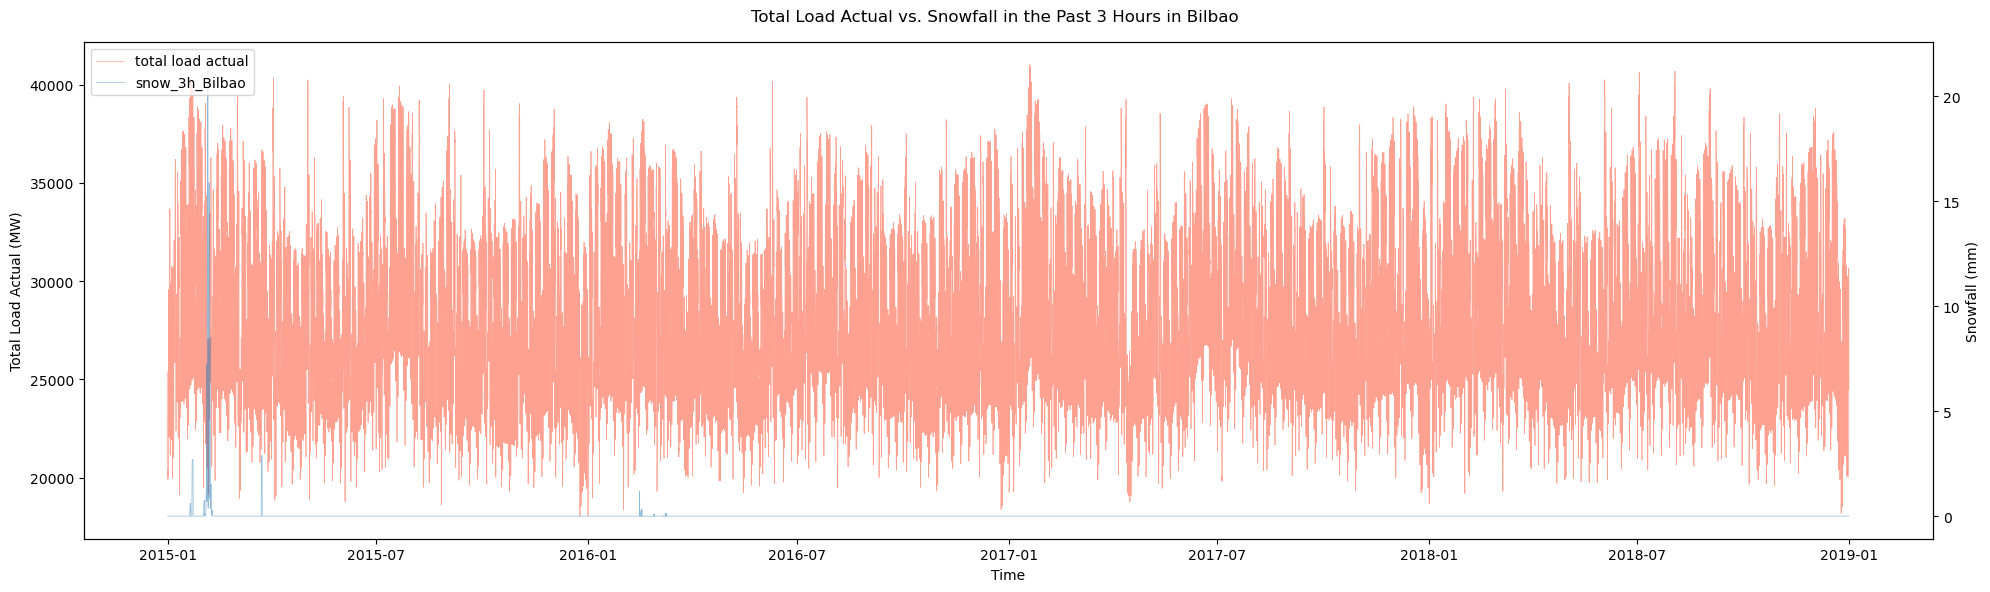

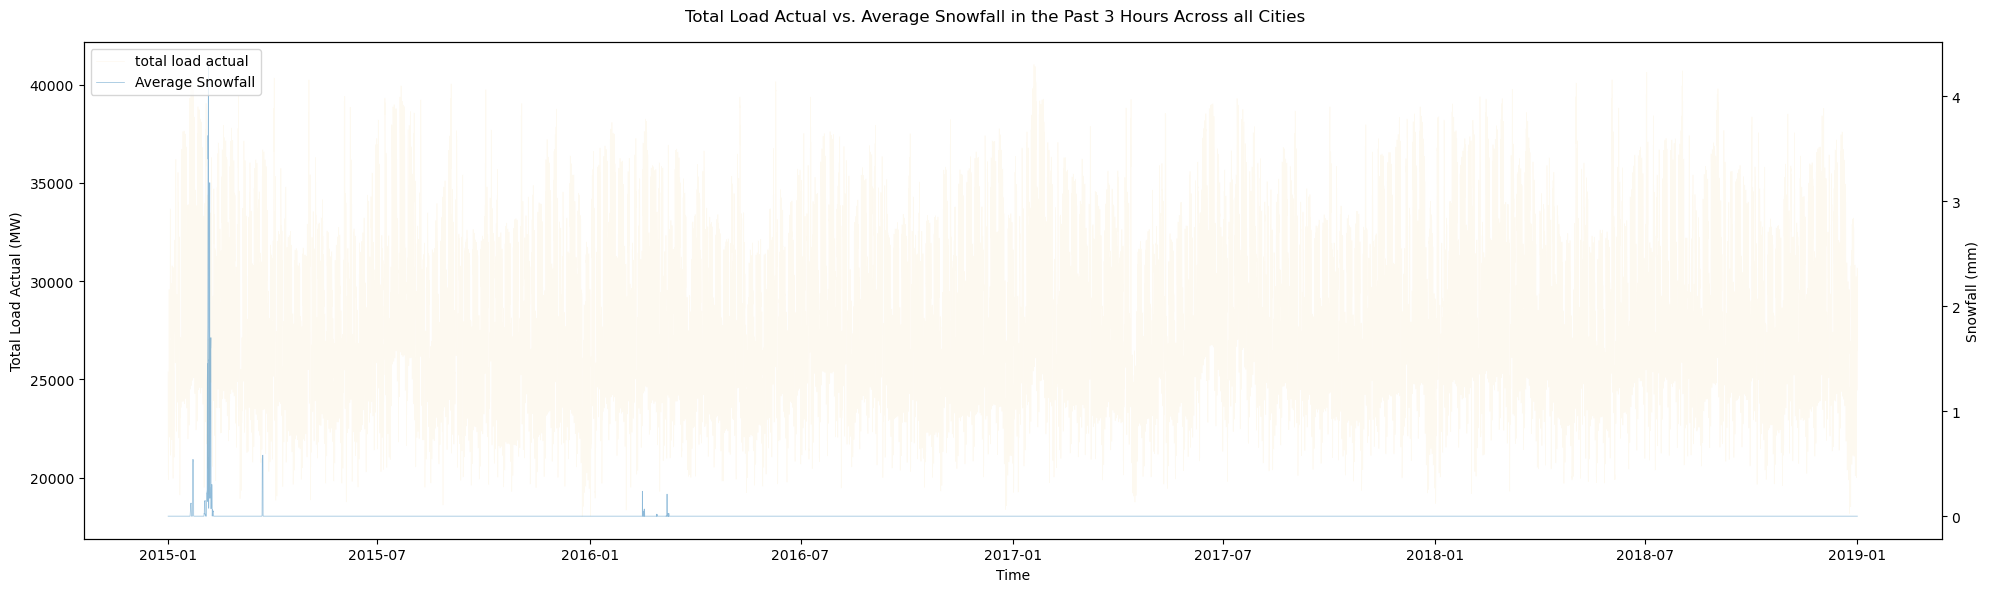

In [93]:
plot_city_comp_bp(df, "snow_3h", cities)

snowfall_by_city = ['snow_3h_Valencia', 'snow_3h_Madrid', 'snow_3h_Bilbao', 'snow_3h_Barcelona', 'snow_3h_Seville']
temp_df = df3[[TARGET] + snowfall_by_city].copy()
temp_df["Average Snowfall"] = temp_df[snowfall_by_city].mean(axis=1)
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Snowfall (mm)":snowfall_by_city}, "Total Load Actual vs. Snowfall in the Past 3 Hours per City")
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Snowfall (mm)":['snow_3h_Bilbao']}, "Total Load Actual vs. Snowfall in the Past 3 Hours in Bilbao")
plot_target_v_weather(temp_df, {"Total Load Actual (MW)":[TARGET]}, {"Snowfall (mm)":["Average Snowfall"]}, "Total Load Actual vs. Average Snowfall in the Past 3 Hours Across all Cities")

From the results above, it is quite apparent that Bilbao has a significant number of large outliers for snowfall. 

Bilbao typically receives very little snow annually, with total accumulation averaging around 20 mm, spread over just a few days. Snowfall is rare and light, occurring mostly in the winter months, particularly in January and February.

**Source:** https://www.weather-atlas.com/en/spain/bilbao-climate

Let’s investigate this further by examining the hourly periods where the snowfall recorded over the past 3 hours exceeded 10 mm.

In [97]:
bilbao_snow = temp[(temp["city_name"]=="Bilbao") & (temp["snow_3h"] > 10)]
bilbao_snow = add_time_features(bilbao_snow)
bilbao_snow[['city_name', 'snow_3h', 'month', 'year','season']]

city_name  snow_3h  month  year  season
time                                                             
2015-02-04 10:00:00+01:00    Bilbao   13.200      2  2015  Winter
2015-02-04 11:00:00+01:00    Bilbao   13.200      2  2015  Winter
2015-02-04 12:00:00+01:00    Bilbao   13.200      2  2015  Winter
2015-02-04 13:00:00+01:00    Bilbao   17.000      2  2015  Winter
2015-02-04 14:00:00+01:00    Bilbao   17.000      2  2015  Winter
2015-02-04 15:00:00+01:00    Bilbao   17.000      2  2015  Winter
2015-02-04 16:00:00+01:00    Bilbao   19.900      2  2015  Winter
2015-02-04 17:00:00+01:00    Bilbao   19.900      2  2015  Winter
2015-02-04 18:00:00+01:00    Bilbao   19.900      2  2015  Winter
2015-02-04 19:00:00+01:00    Bilbao   20.900      2  2015  Winter
2015-02-04 20:00:00+01:00    Bilbao   20.900      2  2015  Winter
2015-02-04 21:00:00+01:00    Bilbao   20.900      2  2015  Winter
2015-02-04 22:00:00+01:00    Bilbao   21.500      2  2015  Winter
2015-02-04 23:00:00+01:00    Bilbao   21.500      2  2015  Winter
2015-02-05 00:00:00+01:00    Bilbao   21.500      2  2015  Winter
2015-02-05 19:00:00+01:00    Bilbao   12.500      2  2015  Winter
2015-02-05 20:00:00+01:00    Bilbao   12.500      2  2015  Winter
2015-02-05 21:00:00+01:00    Bilbao   12.500      2  2015  Winter
2015-02-05 22:00:00+01:00    Bilbao   15.875      2  2015  Winter
2015-02-05 23:00:00+01:00    Bilbao   15.875      2  2015  Winter
2015-02-06 00:00:00+01:00    Bilbao   15.875      2  2015  Winter

In [98]:
temp_df[snowfall_by_city].describe().round(3)

snow_3h_Valencia  snow_3h_Madrid  snow_3h_Bilbao  snow_3h_Barcelona  \
count         35064.000       35064.000       35064.000            35064.0   
mean              0.000           0.000           0.024                0.0   
std               0.012           0.006           0.501                0.0   
min               0.000           0.000           0.000                0.0   
25%               0.000           0.000           0.000                0.0   
50%               0.000           0.000           0.000                0.0   
75%               0.000           0.000           0.000                0.0   
max               1.125           1.049          21.500                0.0   

       snow_3h_Seville  
count          35064.0  
mean               0.0  
std                0.0  
min                0.0  
25%                0.0  
50%                0.0  
75%                0.0  
max                0.0

Since our snowfall data is recorded on a different scale, validating it can be quite challenging. However, based on the feature representation (i.e., snowfall over the past 3 hours), the increments are not very significant when considering data overlap. For simplicity, given that peak snowfall recorded over the past 3 hours is roughly equivalent to the average annual accumulation, we will assume the feature is accurate. Although there seems to be limited data recorded, which may not be highly useful for modeling, we will retain this feature and evaluate its significance during the feature selection phase.

## 3.4 Other Features

For wind-related features—'wind_speed' and 'wind_deg', which provide wind speed and direction respectively—'cloud_all', which indicates cloud coverage, and 'rain_1h', which reports the amount of rainfall (in mm) over the past hour, an in-depth interpretation may not be necessary for our analysis. These features have a direct relationship with the generation features we examined in the energy data. Understanding these features in detail might require specialized knowledge, such as the optimal placement of onshore wind generators and solar panels. However, since these features directly impact electricity generation—as demonstrated by our analysis of the energy dataset—we will retain them for the modeling process. Their significance will be evaluated during feature selection.

Additionally, during our analysis, when we removed duplicate hourly periods, we chose to keep the first entry of each duplicate period per city, as the only differences were in the qualitative features. Since we initially ignored these qualitative features while dropping duplicates, there is a possibility that we may have inadvertently included or excluded some correct values. Therefore, we will now address these duplicates, considering the qualitative features as well.

Lastly, based on our analysis of the energy dataset, including a rain feature would be valuable. However, we observed that the recorded rainfall from the past 3 hours was consistently much less than the recorded rainfall from the past hour. Consequently, we will drop the 'rain_3h' feature.

# 4.0 Final Note

Overall, we have decided to drop the following features: 'rain_3h','weather_id', 'weather_main', 'weather_description', 'weather_icon'

In [89]:
df.drop(['weather_id', 'weather_main', 'weather_description', 'weather_icon'], axis=1, inplace=True)

For a sanity check, let's check if we have properly addressed the erroneous values identified through our research.

In [90]:
df.describe().round(3)

temp    temp_min    temp_max    pressure    humidity  wind_speed  \
count  175320.000  175320.000  175320.000  175320.000  175320.000  175320.000   
mean       16.558      15.278      18.022    1016.205      68.032       2.469   
std         8.025       7.948       8.614      11.607      21.838       2.063   
min       -10.910     -10.910     -10.910     950.000       0.000       0.000   
25%        10.680       9.635      11.759    1013.000      53.000       1.000   
50%        16.000      15.000      17.000    1018.000      72.000       2.000   
75%        22.090      21.000      24.000    1022.000      87.000       4.000   
max        42.450      42.000      48.000    1045.000     100.000      43.000   

         wind_deg     rain_1h     snow_3h  clouds_all  
count  175320.000  175320.000  175320.000  175320.000  
mean      166.725       0.069       0.005      24.344  
std       116.549       0.386       0.225      30.340  
min         0.000       0.000       0.000       0.000  
25%        56.000       0.000       0.000       0.000  
50%       178.000       0.000       0.000      16.000  
75%       270.000       0.000       0.000      40.000  
max       360.000      12.000      21.500     100.000


Out of curiosity, let's quickly examine the Pearson correlation to see if there are any linear relationships among the weather features.

In [91]:
corr = df.loc[:, df.columns != "city_name"].corr(method='pearson')
abs(corr[(corr>0.5) & (corr < 1)]).stack()

temp      temp_min    0.974496
          temp_max    0.966927
temp_min  temp        0.974496
          temp_max    0.892452
temp_max  temp        0.966927
          temp_min    0.892452
dtype: float64

Overall, it is not surprising that the temperature features are all highly correlated with one another.

In [ ]:
save_file(df, "weather_features_clean.csv")